<a href="https://colab.research.google.com/github/HICHAMKALKHA/Storage-location-assignement-problem-/blob/main/Storage_location_assignement_contribution_Simulation_Hicham_KALKHA_L2IACS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```

```
# **I. Products clustering**

E-commerce dataset: downloadable from :https://www.kaggle.com/code/surekharamireddy/e-commerce-data-set

In [ ]:
! pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


*Configure kaggle & colab*

In [ ]:
! cp '/content/drive/MyDrive/kaggle/kaggle.json' ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                    title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                        DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           2776        239  1.0              
bhavikjikadara/car-price-prediction-dataset            Car Price Prediction Dataset                  4KB  2023-12-23 07:07:54            975         29  0.9411765        
thedevastator/global-video-game-sales-and-reviews      Global Video Game Sales and Reviews          56KB  2023-12-20 06:36:51            908         24  1.0              
vassyesboy/netflix-engagement-jan-jun-23               Netflix Engagement (Jan - Jun 23) +           2MB  2023-12-15 11:58:07           1059     

In [ ]:
! kaggle datasets download -d carrie1/ecommerce-data

  0% 0.00/7.20M [00:00<?, ?B/s]
100% 7.20M/7.20M [00:00<00:00, 78.8MB/s]


In [ ]:
! unzip /content/drive/MyDrive/kaggle/ecommerce-data.zip -d  SLAP_clustering

Archive:  /content/drive/MyDrive/kaggle/ecommerce-data.zip
  inflating: SLAP_clustering/data.csv  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
Mydata = '/content/drive/MyDrive/kaggle/SLAP_clustering/data.csv'


Mounted at /content/drive


**Import libraries **

In [ ]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00


In [ ]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=60000f5a35e48bf7e6ee49e273bde63003b1b2dc97aa6565e6286c85ebeded25
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from itertools import accumulate
import os
import shutil
from google.colab import files
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.cluster import DBSCAN
from tslearn.metrics import dtw_subsequence_path
from tslearn.clustering import TimeSeriesKMeans
import math
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from minisom import MiniSom
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from keras.preprocessing.sequence import pad_sequences  # Import pad_sequences for padding
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import numpy as np
from collections import defaultdict
from collections import Counter, defaultdict


In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')



```

```
# *Explore original data*

In [ ]:

# le nombre de lignes et de colonnes dans le DataFrame
nombre_de_lignes = data.shape
print("datashape :", nombre_de_lignes)

# Afficher les noms des colonnes
noms_des_colonnes = data.columns
print("columns :", noms_des_colonnes)

# periode_globale
periode_globale = data["InvoiceDate"].min(), data["InvoiceDate"].max()
print("business period :", periode_globale)

# compter le nombre de valeurs uniques dans la colonne "stockcode"
nombre_de_stockcode = data["StockCode"].nunique()
print("number of items :", nombre_de_stockcode)

datashape : (541909, 8)
columns : Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
business period : ('1/10/2011 10:04', '9/9/2011 9:52')
number of items : 4070



```

```
# *Data Preprocessing*

1: Eliminate negative quantities

2: Identify top pareto ' 20% of items that generate 80% of mouvements (class A)

3: Convert invoiceDate&time to numbers

4: Merge quantities shipped in the same day for each Item.

5: Set dataframe uniform in lenght

6: Normalization (min-max scaler)



**1) Eliminate rows with negative quantity**

In [ ]:
data = data[data['Quantity'] >= 0]

**2) Identify top pareto ' 20% of items that generate 80% of mouvements (class A)**

In [ ]:
# Number of Items before filtering
num_stockcodes_before = len(data['StockCode'].unique())

# 20% of stockcodes that generate 80% of mouvements  (80% of impact)
stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

# Number of Items after filtering
num_stockcodes_after = len(top_stockcodes)



**3) Convert 'InvoiceDate' to day number**

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.minute + pd.to_datetime(data['InvoiceDate']).dt.dayofyear * 24 * 60


**4) Merge quantities shipped in the same day for each Item.**

In [ ]:

# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of rows in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


**6) Data normalization**

In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# List to store normalized series; we prefer to work with csv files for debugging matter
mydataset_normalized = []

# Loop through each file path in mydataset
for file_path in mydataset:
    # Read the CSV data
    series_data = pd.read_csv(file_path)

    # Extract the columns we want to keep and normalize
    invoicedate_column = series_data['InvoiceDate']
    quantity_column = series_data['Quantity']

    # Normalize the quantity column and reshape it
    normalized_quantity = scaler.fit_transform(quantity_column.values.reshape(-1, 1))
    normalized_quantity = normalized_quantity.reshape(len(normalized_quantity))

    # Create a DataFrame with the normalized quantity and original invoicedate columns
    normalized_series_data = pd.DataFrame({f'InvoiceDate_{file_path}': invoicedate_column, f'Normalized_{file_path}': normalized_quantity})

    mydataset_normalized.append(normalized_series_data)

print("Normalization is done!")

Normalization is done!


In [ ]:
print(len(mydataset_normalized))

788



```

```
# *Clustering*

1: Hierarchical clustering

2: Self-Organizing Map (SOM)

3: K-Mean with dynamic time warping (DTW)



**1) Hierarchical clustering**



*Elbow method & Silhouette score to identify the best number of clusters*


In [ ]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

data_3d = np.array([series.values for series in mydataset_normalized])

# Pad or truncate each time series to the maximum length
max_length = max(len(series) for series in mydataset_normalized)
data_2d_padded = pad_sequences(data_3d, maxlen=max_length, padding='post', dtype='float32', truncating='post')

# Reshape data_2d_padded into a 2D array
num_series, num_time_points = data_2d_padded.shape[:2]
data_2d = data_2d_padded.reshape(num_series, -1)

# Initialize a list to store the sum of squared distances (inertia) for each value of num_clusters
inertia_values = []

# Define a range of values for num_clusters to try
cluster_range = range(2, 60)

# Calculate inertia for each value of num_clusters
for num_clusters in cluster_range:
    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='complete')
    cluster_labels = clustering.fit_predict(data_2d)

    # Calculate inertia and append it to the list
    linked = linkage(data_2d, method='complete')
    inertia = linked[-(num_clusters - 1), 2]  # Inertia is the distance at which clusters merge
    inertia_values.append(inertia)
# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)

# Highlight the optimal number of clusters (you can adjust this based on your interpretation of the plot)
optimal_clusters = 13
plt.scatter(optimal_clusters, inertia_values[optimal_clusters - 2], c='red', marker='X', s=200, label='Optimal Clusters')
plt.legend()

plt.show()


<ipython-input-13-1d8f8246b6dd>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_3d = np.array([series.values for series in mydataset_normalized])


<ipython-input-14-ff9f435e8f50>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_3d = np.array([series.values for series in mydataset_normalized])


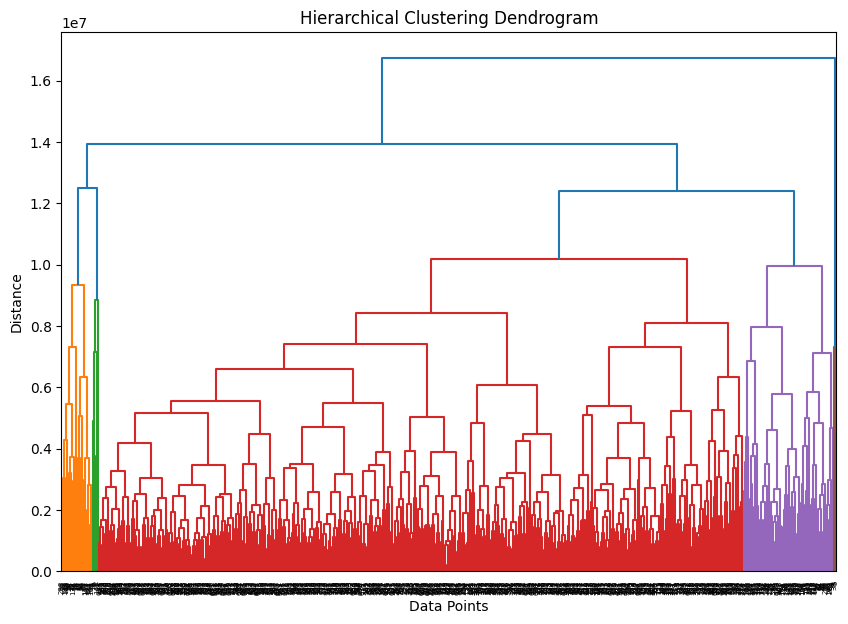

Average Silhouette Score: 0.2186
Cluster 0 contains files: 84077.csv, 22492.csv, 22616.csv, 15036.csv, 71459.csv, 22998.csv, 20971.csv, 22489.csv, 22988.csv, 84970S.csv, 21985.csv, 21094.csv, 23293.csv, 22417.csv, 22189.csv, 22029.csv, 22560.csv, 21891.csv, 23204.csv, 84692.csv, 21914.csv, 22951.csv, 84988.csv, 23200.csv, 21086.csv, 23170.csv, 22328.csv, 22595.csv, 22771.csv, 21121.csv, 21889.csv, 22585.csv, 22147.csv, 22149.csv, 22556.csv, 84970L.csv, 21231.csv, 22555.csv, 82600.csv, 84836.csv, 22561.csv, 23205.csv, 21210.csv, 22759.csv, 21668.csv, 22983.csv, 21669.csv, 22084.csv, 21976.csv, 22661.csv, 84997D.csv, 22652.csv, 84596B.csv, 20676.csv, 21672.csv, 20711.csv, 22900.csv, 22996.csv, 20718.csv, 22557.csv, 21169.csv, 22908.csv, 21670.csv, 82582.csv, 84375.csv, 21174.csv, 22553.csv, 21314.csv, 84997B.csv, 22297.csv, 22646.csv, 85150.csv, 21165.csv, 22219.csv, 22979.csv, 21154.csv, 21936.csv, 21238.csv, 15056N.csv, 21559.csv, 82581.csv, 22413.csv, 23182.csv, 21908.csv, 22367.csv, 

In [ ]:


data_3d = np.array([series.values for series in mydataset_normalized])
max_length = max(len(series) for series in mydataset_normalized)

# Pad or truncate each time series to the maximum length
data_2d_padded = pad_sequences(data_3d, maxlen=max_length, padding='post', dtype='float32', truncating='post')

# Reshape data_2d_padded into a 2D array
num_series, num_time_points = data_2d_padded.shape[:2]
data_2d = data_2d_padded.reshape(num_series, -1)

# Specify the number of clusters you want
num_clusters = 13 # obtained from the elbow method

# Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='complete')#https://jbhender.github.io/Stats506/F18/GP/Group10.html ; ward linkage;
cluster_labels = clustering.fit_predict(data_2d)

# Create a linkage matrix for the dendrogram
linked = linkage(data_2d, method='complete')

# Create a dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Calculate silhouette score for the entire dataset
silhouette_avg = silhouette_score(data_2d, cluster_labels)
print(f"Average Silhouette Score: {silhouette_avg:.4f}")

# Create a dictionary to store file names in each cluster
cluster_files = {cluster: [] for cluster in range(num_clusters)}

# Assuming mydataset_normalized contains your CSV file names
file_names = [str(file_path) for file_path in mydataset]

# Assign file names to clusters based on cluster_labels
for i, label in enumerate(cluster_labels):
    cluster_files[label].append(file_names[i])

# Print the file names in each cluster
for cluster, files in cluster_files.items():
    print(f"Cluster {cluster} contains files: {', '.join(files)}")#ITEMS

# Create a DataFrame with the CSV file names and their cluster assignments
df_HC = pd.DataFrame({'Items': file_names, 'Cluster': cluster_labels})

# Save the DataFrame to an Excel file
df_HC.to_csv('hierarchical_cluster_assignments.csv', index=False)


In [ ]:
from google.colab import files
filename = 'hierarchical_cluster_assignments.csv'

# Save the file to your local machine
df_HC.to_csv(filename, index=False)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**2) Self-Organizing Map (SOM)**

In [ ]:


# Calculate the dimensions of the SOM grid ==> (length of our dataset)²
som_x = som_y = math.ceil(math.sqrt(math.sqrt(math.sqrt(len(mydataset_normalized)))))

# Prepare Reshape data to a 2D array and pad sequences
max_length = max(len(series) for series in mydataset_normalized)
data_2d_padded = pad_sequences([series[f'Normalized_{mydataset_normalized}'].values for series, mydataset_normalized in zip(mydataset_normalized, mydataset)],
                               maxlen=max_length, padding='post', dtype='float32', truncating='post')

# Flatten the padded 2D array
data_2d = data_2d_padded.reshape(data_2d_padded.shape[0], -1)

# The range of hyperparameter values for sigma and learning_rate
sigma_values = [0.1, 0.3, 0.5, 0.7, 1.0]
learning_rate_values = [0.1, 0.3, 0.5, 0.7, 1.0]

best_silhouette_score = -1
best_sigma = None
best_learning_rate = None

# Perform grid search
for sigma in sigma_values:
    for learning_rate in learning_rate_values:
        som = MiniSom(som_x, som_y, data_2d.shape[1], sigma=sigma, learning_rate=learning_rate)
        som.random_weights_init(data_2d)

        num_epochs = 600
        for epoch in range(num_epochs):
            data_point_idx = np.random.randint(data_2d.shape[0])
            som.update(data_2d[data_point_idx], som.winner(data_2d[data_point_idx]), epoch, num_epochs)

        cluster_assignments = np.array([som.winner(series)[0] * som_y + som.winner(series)[1] for series in data_2d])
        silhouette_avg = silhouette_score(data_2d, cluster_assignments)

        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_sigma = sigma
            best_learning_rate = learning_rate

# Print the best hyperparameters and silhouette score
print(f"Best sigma: {best_sigma}")
print(f"Best learning_rate: {best_learning_rate}")


Best sigma: 0.1
Best learning_rate: 1.0


In [ ]:


# Calculate the dimensions of the SOM grid==> (length of our dataset)²
som_x = som_y = math.ceil(math.sqrt(math.sqrt(math.sqrt(len(mydataset_normalized)))))

# Prepare data and pad sequences
max_length = max(len(series) for series in mydataset_normalized)
data_2d_padded = pad_sequences([series[f'Normalized_{mydataset_normalized}'].values for series, mydataset_normalized in zip(mydataset_normalized, mydataset)],
                               maxlen=max_length, padding='post', dtype='float32', truncating='post')

# Flatten the padded 2D array
data_2d = data_2d_padded.reshape(data_2d_padded.shape[0], -1)

# Create and train SOM
som = MiniSom(som_x, som_y, data_2d.shape[1], sigma=best_sigma, learning_rate=best_learning_rate)  # values obtained from hyperparameter tuning
som.random_weights_init(data_2d)
num_epochs = 600  # Adjusted manually
for epoch in range(num_epochs):
    data_point_idx = np.random.randint(data_2d.shape[0])
    som.update(data_2d[data_point_idx], som.winner(data_2d[data_point_idx]), epoch, num_epochs)

# Get cluster assignments
cluster_assignments = np.array([som.winner(series)[0] * som_y + som.winner(series)[1] for series in data_2d])

# Calculate silhouette score
silhouette_avg = silhouette_score(data_2d, cluster_assignments)

print(f"SOM clustering done!")
print(f"Silhouette Score: {silhouette_avg:.4f}")


SOM clustering done!
Silhouette Score: 0.2556


In [ ]:

# Count the occurrences of each cluster assignment
cluster_counts = Counter(cluster_assignments)

# Print the number of times each cluster appears
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster} contains {count} series")

# Create a dictionary to store file names in each cluster
cluster_files = defaultdict(list)

# Assuming mydataset_normalized contains your CSV file names
# Replace this with the actual list of file names
file_names = [str(mydataset_normalized) for mydataset_normalized in mydataset]

# Assign file names to clusters based on cluster_assignments
for i, label in enumerate(cluster_assignments):
    cluster_files[label].append(file_names[i])

# Print the CSV files in each cluster
for cluster, files in cluster_files.items():
    print(f"Cluster {cluster} contains files: {', '.join(files)}")


# Create a DataFrame with the CSV file names and their cluster assignments
df_som = pd.DataFrame({'Items': file_names, 'Cluster': cluster_assignments})

# Save the DataFrame to an Excel file
df_som.to_csv('som_cluster_assignments.csv', index=False)


Cluster 5 contains 771 series
Cluster 2 contains 1 series
Cluster 8 contains 1 series
Cluster 3 contains 1 series
Cluster 4 contains 2 series
Cluster 7 contains 4 series
Cluster 0 contains 1 series
Cluster 6 contains 6 series
Cluster 1 contains 1 series
Cluster 5 contains files: 23843.csv, 23166.csv, 22197.csv, 84077.csv, 85099B.csv, 85123A.csv, 84879.csv, 21212.csv, 23084.csv, 22492.csv, 22616.csv, 21977.csv, 22178.csv, 15036.csv, 17003.csv, 21915.csv, 22386.csv, 23203.csv, 22086.csv, 84946.csv, 84991.csv, 22355.csv, 22469.csv, 20724.csv, 85099F.csv, 84755.csv, 22961.csv, 22693.csv, 22952.csv, 21213.csv, 22151.csv, 23199.csv, 21790.csv, 22629.csv, 21731.csv, 85099C.csv, 22423.csv, 84568.csv, 84826.csv, 21931.csv, 71459.csv, 23201.csv, 84992.csv, 16014.csv, 20713.csv, 20719.csv, 23209.csv, 21080.csv, 20668.csv, 21181.csv, 22993.csv, 22411.csv, 22383.csv, 22969.csv, 84978.csv, 22998.csv, 21975.csv, 20727.csv, 21175.csv, 23206.csv, 23307.csv, 23310.csv, 21232.csv, 20728.csv, 22630.csv, 2

In [ ]:
from google.colab import files
# Save the DataFrame to an Excel file
df_som.to_csv('som_cluster_assignments.csv', index=False)
files.download('som_cluster_assignments.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cluster 5 contains 771 series
Cluster 2 contains 1 series
Cluster 8 contains 1 series
Cluster 3 contains 1 series
Cluster 4 contains 2 series
Cluster 7 contains 4 series
Cluster 0 contains 1 series
Cluster 6 contains 6 series
Cluster 1 contains 1 series
Cluster 5 contains files: 23843.csv, 23166.csv, 22197.csv, 84077.csv, 85099B.csv, 85123A.csv, 84879.csv, 21212.csv, 23084.csv, 22492.csv, 22616.csv, 21977.csv, 22178.csv, 15036.csv, 17003.csv, 21915.csv, 22386.csv, 23203.csv, 22086.csv, 84946.csv, 84991.csv, 22355.csv, 22469.csv, 20724.csv, 85099F.csv, 84755.csv, 22961.csv, 22693.csv, 22952.csv, 21213.csv, 22151.csv, 23199.csv, 21790.csv, 22629.csv, 21731.csv, 85099C.csv, 22423.csv, 84568.csv, 84826.csv, 21931.csv, 71459.csv, 23201.csv, 84992.csv, 16014.csv, 20713.csv, 20719.csv, 23209.csv, 21080.csv, 20668.csv, 21181.csv, 22993.csv, 22411.csv, 22383.csv, 22969.csv, 84978.csv, 22998.csv, 21975.csv, 20727.csv, 21175.csv, 23206.csv, 23307.csv, 23310.csv, 21232.csv, 20728.csv, 22630.csv, 2

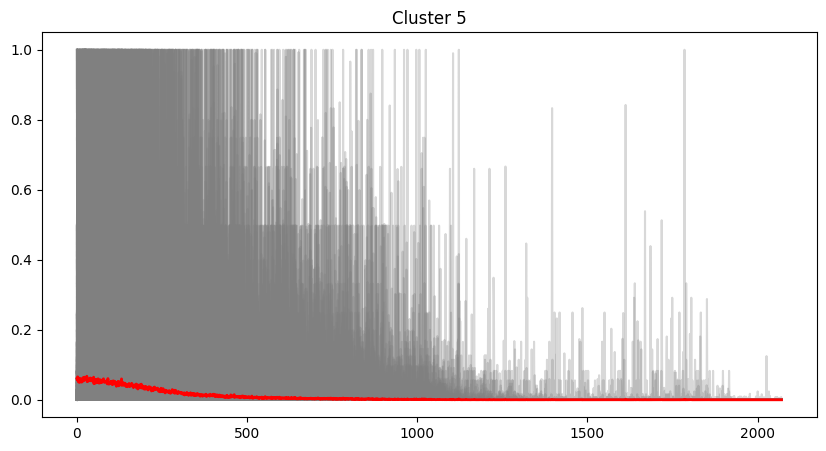

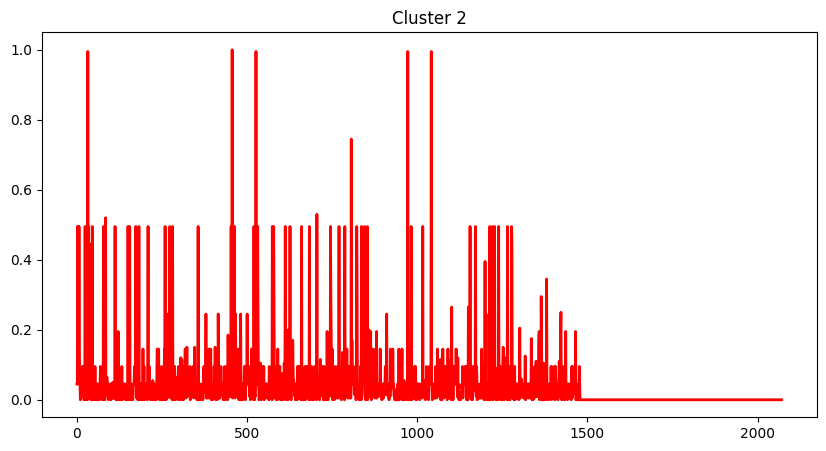

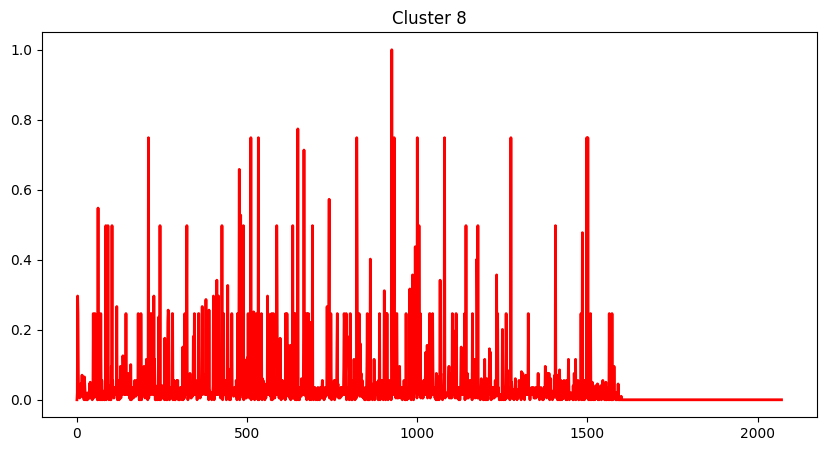

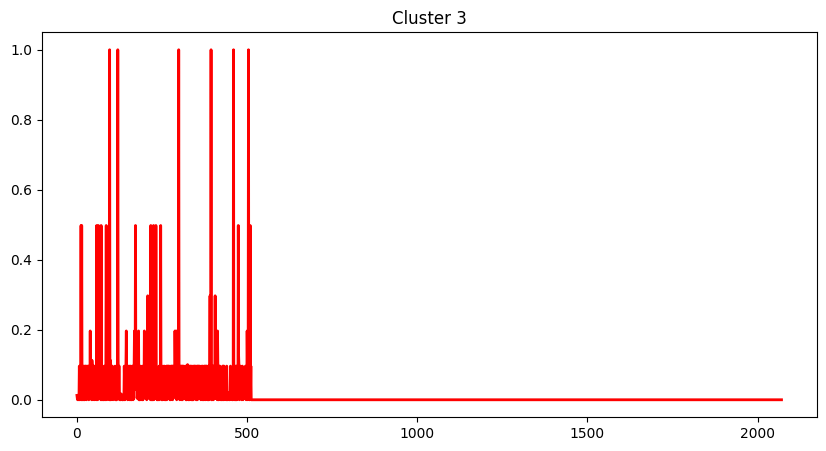

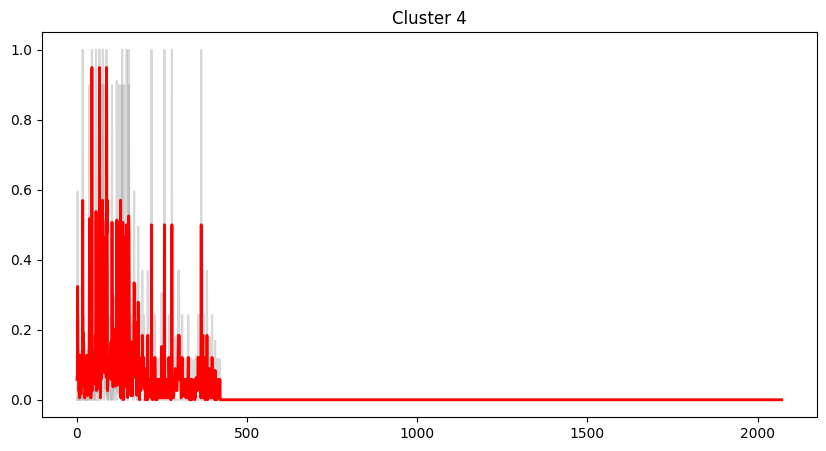

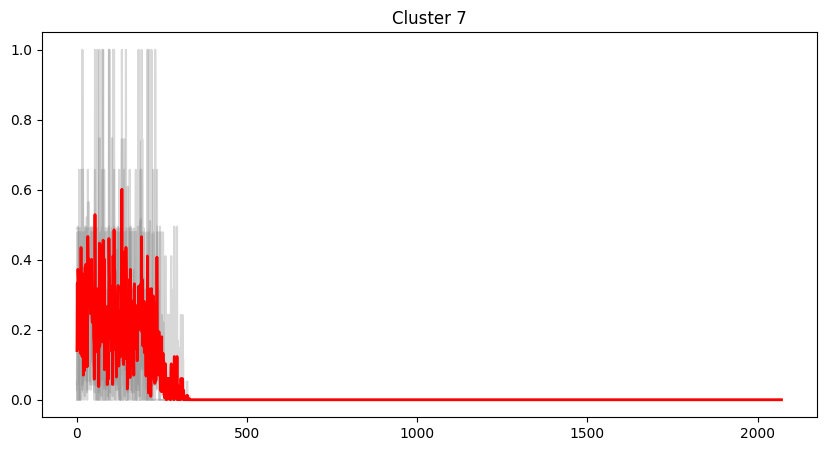

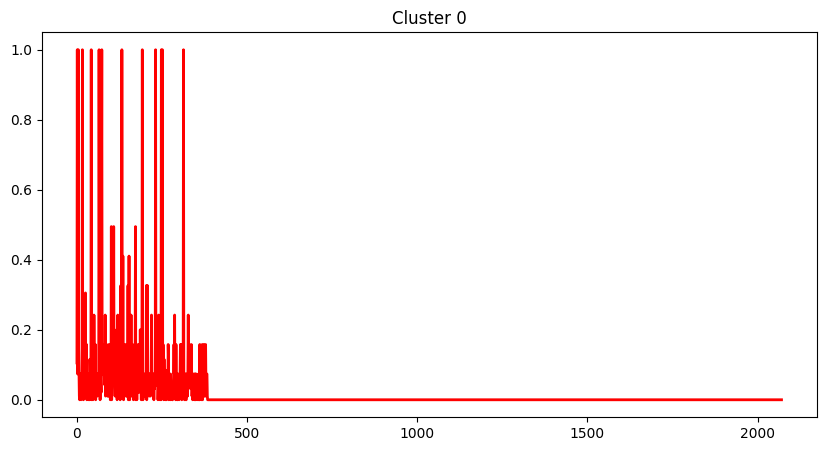

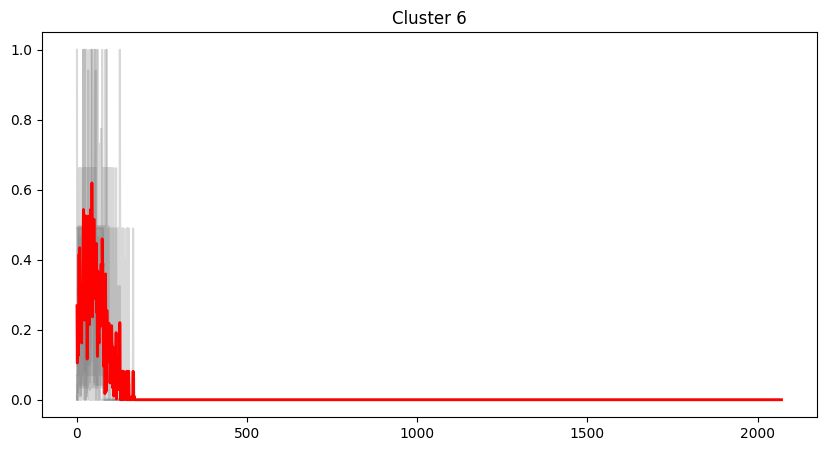

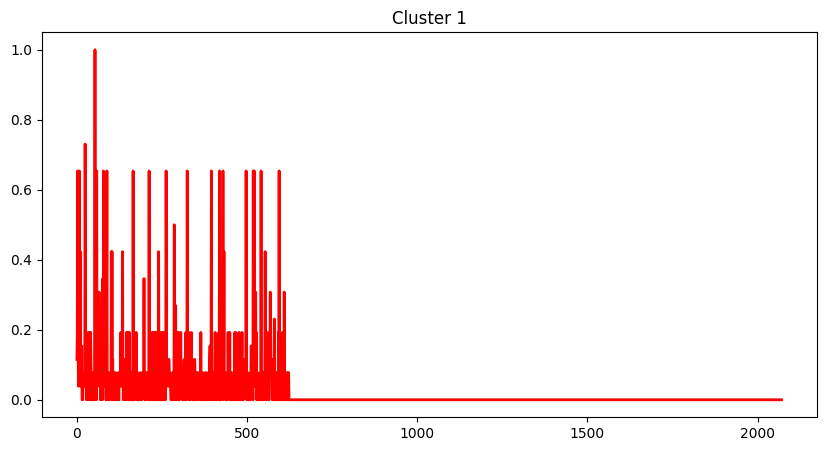

In [ ]:
from google.colab import files

# Count the occurrences of each cluster assignment
cluster_counts = defaultdict(int)
for label in cluster_assignments:
    cluster_counts[label] += 1

# Print the number of times each cluster appears
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster} contains {count} series")

# Create a dictionary to store file names in each cluster
cluster_files = defaultdict(list)

# Replace this with the actual list of file names
file_names = [str(file_path) for file_path in mydataset]

# Assign file names to clusters based on cluster_assignments
for i, label in enumerate(cluster_assignments):
    cluster_files[label].append(file_names[i])

# Print the CSV files in each cluster
for cluster, files in cluster_files.items():
    print(f"Cluster {cluster} contains files: {', '.join(files)}")

# Plot each cluster
for cluster in cluster_files.keys():
    plt.figure(figsize=(10, 5))
    plt.title(f"Cluster {cluster}")
    cluster_indices = np.where(cluster_assignments == cluster)[0]

    for i in cluster_indices:
        plt.plot(data_2d[i], color='gray', alpha=0.3)

    plt.plot(np.mean(data_2d[cluster_indices], axis=0), color='red', linewidth=2)
    plt.show()

# Create a DataFrame with the CSV file names and their cluster assignments
df_som = pd.DataFrame({'Items': file_names, 'Cluster': cluster_assignments})

# Save the DataFrame to an Excel file
df_som.to_csv('som_cluster_assignments.csv', index=False)


**3) K-Mean with dynamic time warping (DTW)**

In [ ]:
from sklearn.metrics import silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from keras.preprocessing.sequence import pad_sequences

# Pad sequences to a common length
max_length = max(len(series) for series in mydataset_normalized)
data_padded = pad_sequences(
    [series[f'Normalized_{file_path}'].values for series, file_path in zip(mydataset_normalized, mydataset)],
    maxlen=max_length, padding='post', dtype='float32', truncating='post'
)

# Rescale the padded data
data_rescaled = TimeSeriesScalerMeanVariance().fit_transform(data_padded)

# Flatten the padded 3D array
data_padded_flatten = data_padded.reshape(data_padded.shape[0], -1)

# Create and train TimeSeriesKMeans with DTW metric in parallel
num_clusters = 13  # Already defined by elbow method
kmeans = TimeSeriesKMeans(n_clusters=num_clusters, metric="euclidean", verbose=True, random_state=0, n_jobs=-1)
kmeans.fit(data_padded_flatten)

# Get cluster assignments from TimeSeriesKMeans
cluster_assignments_tskmeans = kmeans.labels_

# Calculate the average series for each cluster
cluster_series_tskmeans = {cluster: [] for cluster in np.unique(cluster_assignments_tskmeans)}
for i, cluster in enumerate(cluster_assignments_tskmeans):
    cluster_series_tskmeans[cluster].append(data_padded[i])

# Calculate silhouette score
silhouette_avg = silhouette_score(data_padded_flatten, cluster_assignments_tskmeans)

# Print the silhouette score
print(f"Silhouette Score: {silhouette_avg}")

print('K-Mean Euclidean clustering done!')


5.368 --> 3.947 --> 3.913 --> 3.900 --> 3.894 --> 3.889 --> 3.883 --> 3.879 --> 3.876 --> 3.873 --> 3.870 --> 3.864 --> 3.862 --> 3.858 --> 3.856 --> 3.854 --> 3.852 --> 3.851 --> 3.850 --> 3.850 --> 3.849 --> 3.846 --> 3.845 --> 3.843 --> 3.839 --> 3.839 --> 
Silhouette Score: -0.009669403545558453
K-Mean Euclidean clustering done!


5.368 --> 3.947 --> 3.913 --> 3.900 --> 3.894 --> 3.889 --> 3.883 --> 3.879 --> 3.876 --> 3.873 --> 3.870 --> 3.864 --> 3.862 --> 3.858 --> 3.856 --> 3.854 --> 3.852 --> 3.851 --> 3.850 --> 3.850 --> 3.849 --> 3.846 --> 3.845 --> 3.843 --> 3.839 --> 3.839 --> 


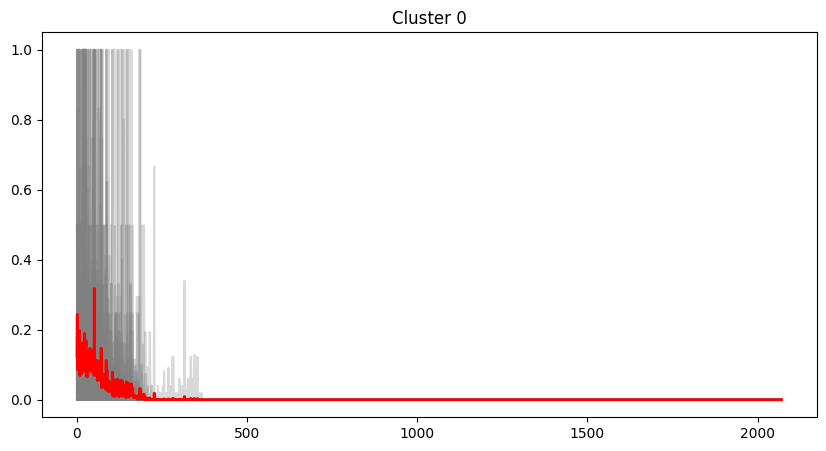

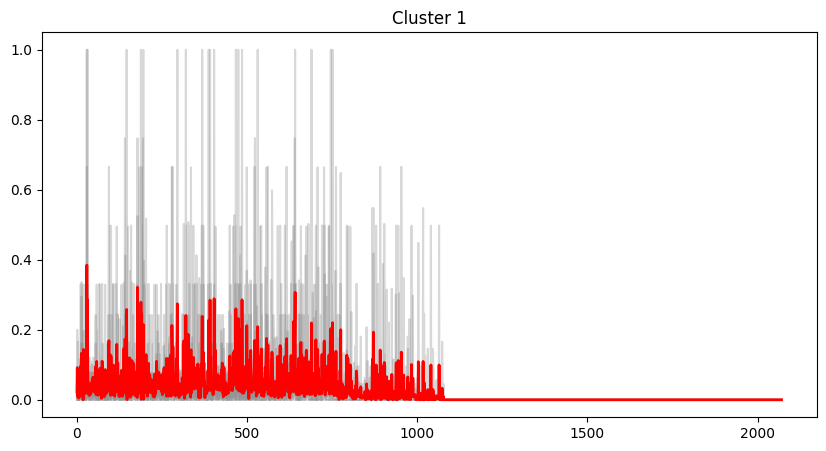

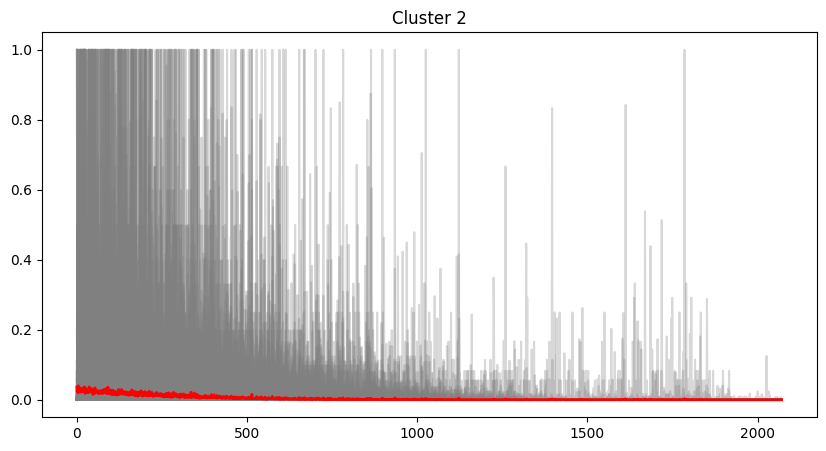

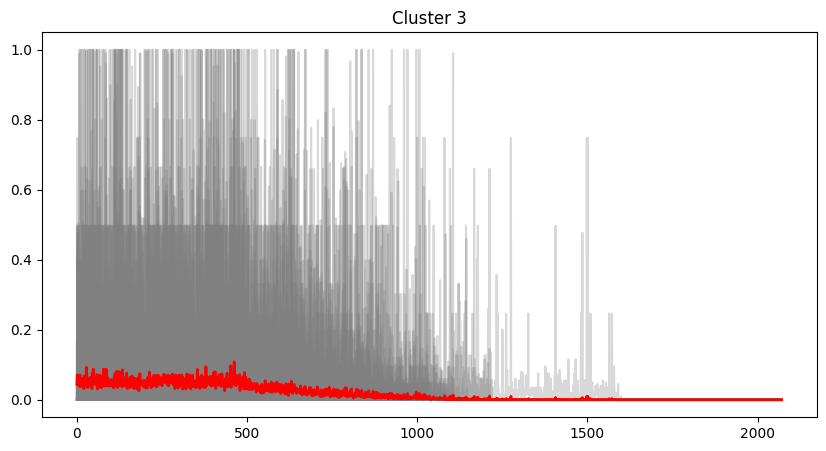

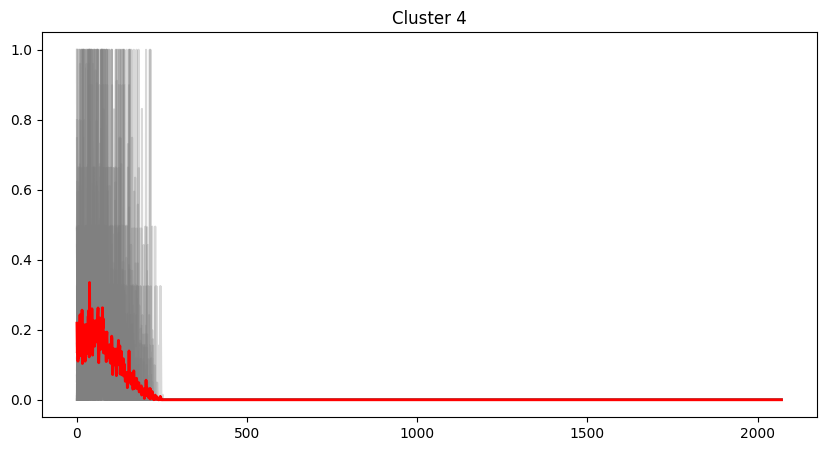

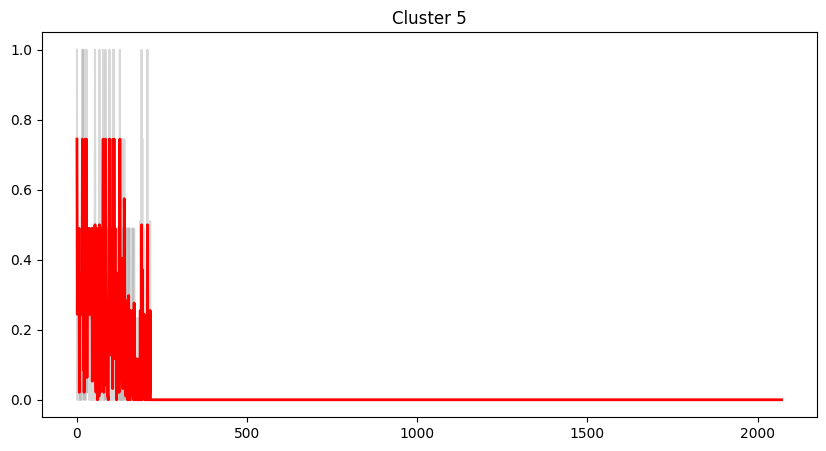

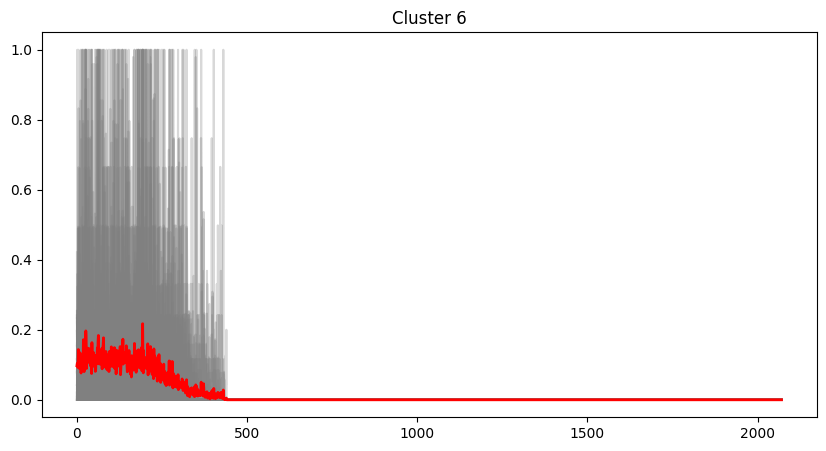

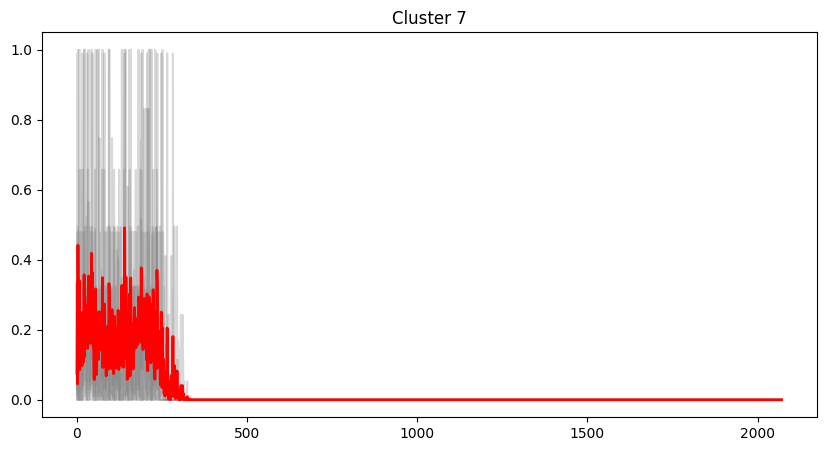

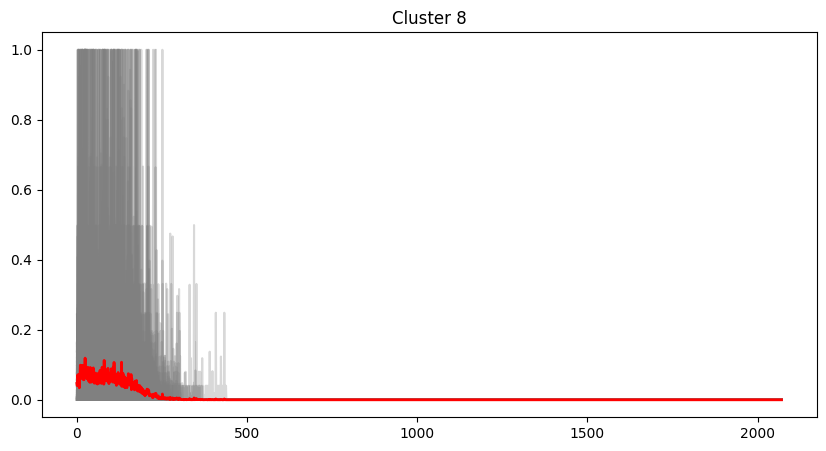

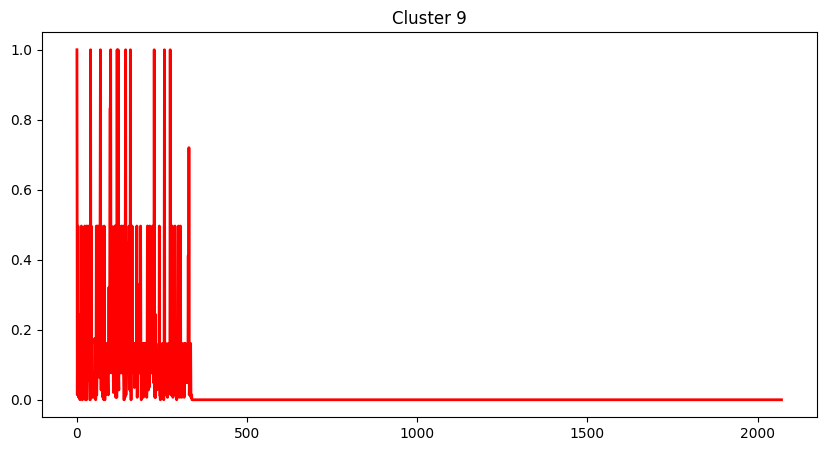

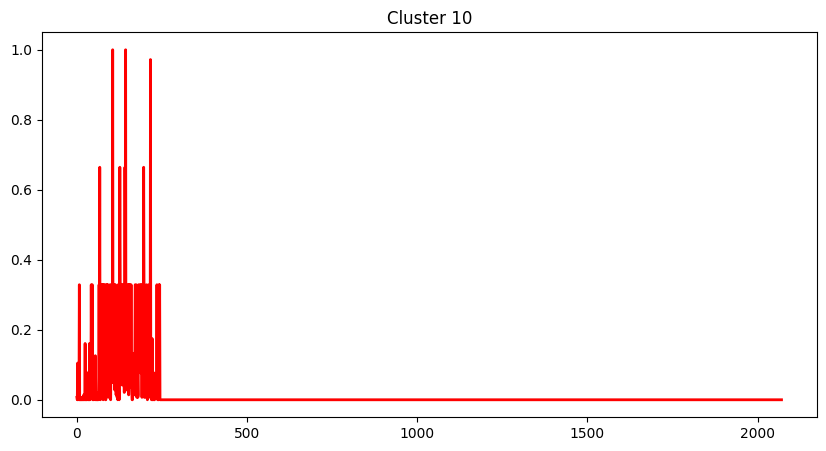

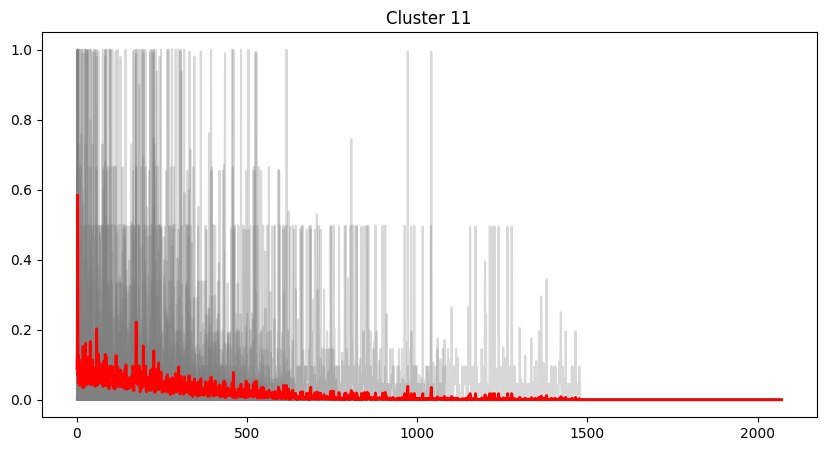

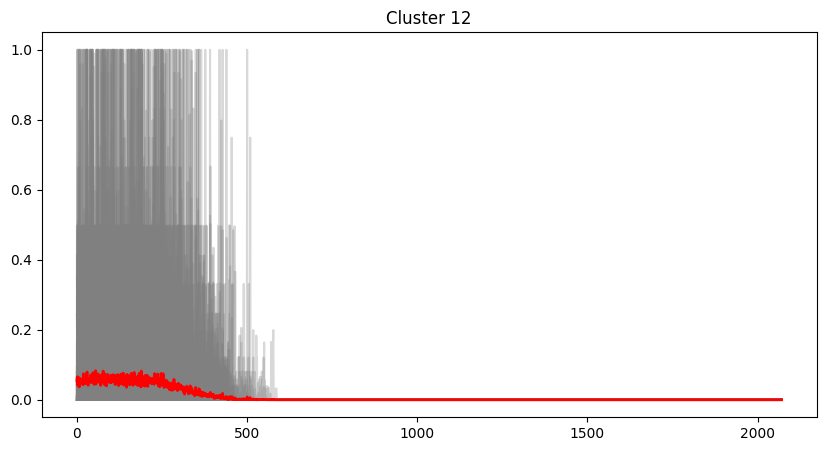

Silhouette Score: -0.009669403545558453


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Pad sequences to a common length
max_length = max(len(series) for series in mydataset_normalized)
data_padded = pad_sequences(
    [series[f'Normalized_{file_path}'].values for series, file_path in zip(mydataset_normalized, mydataset)],
    maxlen=max_length, padding='post', dtype='float32', truncating='post'
)

# Rescale the padded data
data_rescaled = TimeSeriesScalerMeanVariance().fit_transform(data_padded)

# Flatten the padded 3D array
data_padded_flatten = data_padded.reshape(data_padded.shape[0], -1)

# Create and train TimeSeriesKMeans with DTW metric in parallel
num_clusters = 13  # Already defined by elbow method
kmeans = TimeSeriesKMeans(n_clusters=num_clusters, metric="euclidean", verbose=True, random_state=0, n_jobs=-1)
kmeans.fit(data_padded_flatten)

# Get cluster assignments from TimeSeriesKMeans
cluster_assignments_tskmeans = kmeans.labels_

# Calculate the average series for each cluster
cluster_series_tskmeans = {cluster: [] for cluster in np.unique(cluster_assignments_tskmeans)}
for i, cluster in enumerate(cluster_assignments_tskmeans):
    cluster_series_tskmeans[cluster].append(data_padded[i])

# Calculate silhouette score
silhouette_avg = silhouette_score(data_padded_flatten, cluster_assignments_tskmeans)

# Plot each cluster and save the results
for cluster in cluster_series_tskmeans.keys():
    plt.figure(figsize=(10, 5))
    plt.title(f"Cluster {cluster}")
    cluster_indices = np.where(cluster_assignments_tskmeans == cluster)[0]

    for i in cluster_indices:
        plt.plot(data_padded_flatten[i], color='gray', alpha=0.3)

    plt.plot(np.mean(data_padded_flatten[cluster_indices], axis=0), color='red', linewidth=2)
    plt.show()

# Print the silhouette score
print(f"Silhouette Score: {silhouette_avg}")

# Create a DataFrame with the file names and their cluster assignments
df_tskmeans = pd.DataFrame({'Items': file_names, 'Cluster': cluster_assignments_tskmeans})

# Save the DataFrame to a CSV file
df_tskmeans.to_csv('tskmeans_cluster_assignments.csv', index=False)

# Download the CSV file
files.download('tskmeans_cluster_assignments.csv')


In [ ]:
from collections import Counter, defaultdict

# Get cluster assignments from cuml k-means
cluster_assignments_kmeans = kmeans.labels_

# Count the occurrences of each cluster assignment
cluster_counts = Counter(cluster_assignments_kmeans)

# Print the number of times each cluster appears
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster} contains {count} time series")

# Replace this with the actual list of file names
file_names = [str(file_path) for file_path in mydataset]

# Create a dictionary to store file names in each cluster
cluster_files = defaultdict(list)

# Assign file names to clusters based on cluster_assignments_kmeans
for i, cluster in enumerate(cluster_assignments_kmeans):
    cluster_files[cluster].append(file_names[i])

# Print the files in each cluster
for cluster, files in cluster_files.items():
    print(f"Cluster {cluster} contains files: {', '.join(files)}")

# Print silhouette score
print(f"Silhouette Score: {silhouette_avg}")

print('K-Mean euclidean metric clustering done!')


Cluster 2 contains 316 time series
Cluster 12 contains 135 time series
Cluster 11 contains 28 time series
Cluster 4 contains 37 time series
Cluster 3 contains 76 time series
Cluster 1 contains 5 time series
Cluster 6 contains 41 time series
Cluster 8 contains 105 time series
Cluster 9 contains 1 time series
Cluster 0 contains 35 time series
Cluster 7 contains 6 time series
Cluster 10 contains 1 time series
Cluster 5 contains 2 time series
Cluster 2 contains files: 23843.csv, 23166.csv, 22197.csv, 84077.csv, 85099B.csv, 85123A.csv, 84879.csv, 21212.csv, 23084.csv, 21977.csv, 22178.csv, 21915.csv, 22386.csv, 22086.csv, 84991.csv, 22469.csv, 85099F.csv, 22961.csv, 22693.csv, 21213.csv, 23199.csv, 22629.csv, 22423.csv, 84568.csv, 84826.csv, 84992.csv, 16014.csv, 20713.csv, 22969.csv, 21975.csv, 21175.csv, 23307.csv, 21232.csv, 22630.csv, 21137.csv, 20971.csv, 21928.csv, 79321.csv, 21108.csv, 23343.csv, 22470.csv, 22699.csv, 84347.csv, 21703.csv, 22457.csv, 82482.csv, 22909.csv, 16045.csv, 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import silhouette_score

# Pad sequences to a common length
max_length = max(len(series) for series in mydataset_normalized)
data_padded = pad_sequences(
    [series[f'Normalized_{file_path}'].values for series, file_path in zip(mydataset_normalized, mydataset)],
    maxlen=max_length, padding='post', dtype='float32', truncating='post'
)

# Rescale the padded data using PyTorch
data_rescaled = TimeSeriesScalerMeanVariance().fit_transform(data_padded)
data_rescaled_torch = torch.tensor(data_rescaled)

# Flatten the padded 3D array in PyTorch
data_padded_flatten_torch = data_rescaled_torch.view(data_rescaled_torch.size(0), -1)

# Convert to NumPy for cuml (as it doesn't support PyTorch tensors)
data_padded_flatten_np = data_padded_flatten_torch.cpu().numpy()

# Create and train GPU-accelerated k-means using cuml with custom DTW distance
num_clusters = 13  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(data_padded_flatten_np)

# Get cluster assignments from cuml k-means
cluster_assignments_kmeans = kmeans.labels_

# Calculate silhouette score
silhouette_avg = silhouette_score(data_padded_flatten_np, cluster_assignments_kmeans)

# Print cluster assignments
print("Cluster Assignments (GPU-accelerated K-means dtw metric):", cluster_assignments_kmeans)


Cluster Assignments (GPU-accelerated K-means dtw metric): [ 3  1  3  7  3  3  3  3  9  0  9  3  9  9  5  3  3  3  9 12  9 12 12  3
  3  9  3  9  9 10  9  9  2  9  9  3  9  9 12 11  3  3  9  3  9  1  3  9
  9  9  2 12  9  9  9  3  9  8  9  3 10  9  9  2 12  9  9  9  9  9  3  3
  9  9  0  0  0  9  3  9  9  9  0  9 11  9  3  3  9  3  3  9  9  9  0  6
 12  3  9  3  0  3 11  9  3  1  9  1  9  3  0  9  3  3  2  3 12  9  6 12
  9  0 12  8  3  9  0  3  9  6  9  0  2  9  9  9  1  9  9  3  4  1  9  9
  0  3  9  9  3  9  2  3  3  2  9  0 11  0  2  5  9  3 11  9  3  2  9  9
  7  2  9  7  0  9  0  0  5  9  0  2 10  9  9  3  9  6  3  1  9  9  1  8
  0 12  3  0  9  2  9  0  9  6  9 11  3  9  3  2  5  2  9  9  9  1  9  0
  1  9  9  9  9  1  1  9  5  0  0  0  9  4  3  3 11  3  0  0  0  5  1  0
  5  3  0  0  4  0  8  7  9  9  2  0  9  9  0  3  2  0  9  0  2  9  0  3
  5  6  0  2  3  0  2  3  0  8  3  0  2  9  9  8  9  9  0  5  3 12  9  8
  9  0  0  5  2  3  5  2  2  0 12  0  0  0  0  2  5  0  7  0  0  9

In [ ]:
from collections import Counter, defaultdict

# Get cluster assignments from cuml k-means
cluster_assignments_kmeans = kmeans.labels_

# Print the number of times each cluster appears
cluster_counts = Counter(cluster_assignments_kmeans)
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster} contains {count} time series")

file_names = [str(file_path) for file_path in mydataset]

# Assign file names to clusters based on cluster_assignments_kmeans
cluster_files = defaultdict(list)
for i, cluster in enumerate(cluster_assignments_kmeans):
    cluster_files[cluster].append(file_names[i])

for cluster, files in cluster_files.items():
    print(f"Cluster {cluster} contains files: {', '.join(files)}")

# Print silhouette score
print(f"Silhouette Score: {silhouette_avg}")

print('GPU-accelerated K-Mean DTW clustering done!')


Cluster 3 contains 107 time series
Cluster 1 contains 44 time series
Cluster 7 contains 18 time series
Cluster 9 contains 148 time series
Cluster 0 contains 152 time series
Cluster 5 contains 88 time series
Cluster 12 contains 16 time series
Cluster 10 contains 10 time series
Cluster 2 contains 139 time series
Cluster 11 contains 20 time series
Cluster 8 contains 15 time series
Cluster 6 contains 16 time series
Cluster 4 contains 15 time series
Cluster 3 contains files: 23843.csv, 22197.csv, 85099B.csv, 85123A.csv, 84879.csv, 21212.csv, 21977.csv, 21915.csv, 22386.csv, 23203.csv, 22355.csv, 22469.csv, 85099F.csv, 22629.csv, 84826.csv, 21931.csv, 23201.csv, 20713.csv, 22969.csv, 20727.csv, 21929.csv, 20971.csv, 21928.csv, 21108.csv, 23343.csv, 22470.csv, 22699.csv, 21703.csv, 22457.csv, 82482.csv, 16045.csv, 22960.csv, 22385.csv, 23298.csv, 21497.csv, 85152.csv, 21891.csv, 22727.csv, 22720.csv, 84988.csv, M.csv, 16161P.csv, 22379.csv, 22328.csv, 22726.csv, 23245.csv, 22149.csv, 82484.cs

In [ ]:
import pandas as pd
from google.colab import files

# Get cluster assignments from cuml k-means
cluster_assignments_kmeans = kmeans.labels_

df_dtw = pd.DataFrame({'Items': file_names, 'Cluster': cluster_assignments_kmeans})

# Save the cluster assignments to a CSV file
csv_filename = 'kmeans_dtw_cluster_assignments.csv'
df_dtw.to_csv(csv_filename, index=False)

# Download the CSV file
files.download(csv_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


****


```

```
# **II. Picking simulation**



In [ ]:
#import distance matrix
from google.colab import drive
drive.mount('/content/drive')
distance_matrix = pd.read_excel('/content/drive/MyDrive/kaggle/SLAP_clustering/Distance matrix.xlsx')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



```

```
# *Picking Methods and strategies*

A) Picking Strategie: S-Shape/ Picking Method: single order picking// ok  

B) Picking Strategie: S-Shape/ Picking Method: batch order picking  // bacth picking // Définir un batch de x order to be collected at once.

C) Picking Strategie: S-Shape/ Picking Method: Zone order picking// Définir la collect par cluster.

D) Picking Strategie: mid-Point/ Picking Method: single picker  // modify 40 par condition si <10>

E) Picking Strategie: mid-Point/ Picking Method:

F) Picking Strategie: mid-Point/ Picking Method: Zone order picking


### **Ps: We retain only the clustering method with the highest Silhouette score ==> Hierarchical clustering (HC)**
---



## A) Picking Strategie: S-Shape/ Picking Method: single order picking// ok




### **1) AI-driven storage location assignment clustering**

In [ ]:
import pandas as pd
from google.colab import files
# Load the 'hierarchical_cluster_assignments.csv' file
cluster_assignments = df_HC

# Sort the cluster assignments by 'Cluster' column
cluster_assignments = cluster_assignments.sort_values(by='Cluster')

# Calculate the number of items in each cluster
cluster_sizes = cluster_assignments['Cluster'].value_counts()

# Initialize Emplacement counter
emplacement_counter = 1

# Create a new DataFrame to store the results
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Iterate through each cluster
for cluster, size in cluster_sizes.items():
    # Assign Emplacement values from emplacement_counter to emplacement_counter + size - 1
    result_df = pd.concat([result_df, cluster_assignments[cluster_assignments['Cluster'] == cluster]], ignore_index=True)
    result_df.loc[result_df['Cluster'] == cluster, 'Emplacement'] = list(range(emplacement_counter, emplacement_counter + size))

    # Update the Emplacement counter
    emplacement_counter += size
result_df['Items'] = result_df['Items'].str.replace('.csv', '')
# Save the result to a new CSV file
result_df.to_csv('cluster_emplacement_assignments_HC.csv', index=False)

# Download the Excel file to your local machine
files.download('cluster_emplacement_assignments_HC.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd



merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

merged_df.reset_index(drop=True, inplace=True)


<ipython-input-40-5acb52240e25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')


In [ ]:

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_HC'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo'
for invoice_no in merged_df['InvoiceNo'].unique():
    # Filter data for the current 'InvoiceNo'
    invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

    # Check if the DataFrame is not empty
    if not invoice_data.empty:
        # Select relevant columns
        invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]

        # Save the DataFrame to a CSV file
        csv_file_path = f"{output_directory}/Invoice_{invoice_no}.csv"
        invoice_csv_data.to_csv(csv_file_path, index=False)


    else:
        pass


In [ ]:
import pandas as pd
import os

# Function to calculate distance between two positions A and Bin warehouse
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        distance = distance_matrix.loc[i, j-1]
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_HC'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_HC= []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances)

                # Add the total distance to the list
                distances_list_HC.append(total_distance)

                # Print or use the total distance as needed
                print(f" {csv_file}: {total_distance}")
            else:
                print(f"Done {csv_file}")

        except Exception as e:
            print(f"done ")

# Calculate the average distance for all valid CSV files
if distances_list_HC:
    average_distance_HC = sum(distances_list_HC) / len(distances_list_HC)
    print(f"Average distance for all valid CSV files: {average_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_HC = min(distances_list_HC)
    max_distance_HC = max(distances_list_HC)
    std_distance_HC = pd.Series(distances_list_HC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_HC}")
    print(f"Maximum distance: {max_distance_HC}")
    print(f"Standard deviation of distances: {std_distance_HC}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
 Invoice_552444.csv: 450
 Invoice_552563.csv: 832
 Invoice_558923.csv: 194
 Invoice_541106.csv: 70
Done Invoice_571447.csv
Done Invoice_C571925.csv
done 
Done Invoice_C570276.csv
done 
 Invoice_C552556.csv: 390
 Invoice_552669.csv: 774
done 
Done Invoice_C564063.csv
 Invoice_536842.csv: 310
 Invoice_545276.csv: 26
 Invoice_C566084.csv: 232
 Invoice_567094.csv: 454
done 
Done Invoice_C541222.csv
 Invoice_536599.csv: 84
done 
 Invoice_559985.csv: 542
 Invoice_578319.csv: 206
done 
done 
Done Invoice_554953.csv
 Invoice_C540786.csv: 312
 Invoice_564019.csv: 282
 Invoice_576063.csv: 222
 Invoice_544893.csv: 642
done 
 Invoice_544421.csv: 390
done 
 Invoice_536603.csv: 2
 Invoice_549313.csv: 408
Done Invoice_C557874.csv
 Invoice_559302.csv: 384
done 
done 
 Invoice_540096.csv: 284
done 
 Invoice_543005.csv: 232
done 
 Invoice_579265.csv: 84
 Invoice_550286.csv: 248
Done Invoice_556310.csv
 Invoice_547537.csv: 338
done 
 Invoice_552186.csv: 

In [ ]:
# Calculate the average distance for all valid CSV files
if distances_list_HC:
    average_distance_HC = sum(distances_list_HC) / len(distances_list_HC)
    print(f"Average distance for all valid CSV files: {average_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_HC = min(distances_list_HC)
    max_distance_HC = max(distances_list_HC)
    std_distance_HC = pd.Series(distances_list_HC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_HC}")
    print(f"Maximum distance: {max_distance_HC}")
    print(f"Standard deviation of distances: {std_distance_HC}")
else:
    print("No valid CSV files found.")

Average distance for all valid CSV files: 358.79786840352307
Minimum distance (excluding 0s): 2
Maximum distance: 1210
Standard deviation of distances: 210.57327956793287


### **2) Random Storage**

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [ ]:
import random
# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Assign values to result_df
for csv_file in mydataset:
    # Extract item name from the CSV file path
    item_name = csv_file.replace('.csv', '')

    # Assign values to the DataFrame
    result_df = result_df.append({
        'Items': item_name,
        'Cluster': 1,
        'Emplacement': random.randint(1, 788)}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('result_df.csv', index=False)



In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)



In [ ]:

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_RANDOM'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo'
for invoice_no in merged_df['InvoiceNo'].unique():
    # Filter data for the current 'InvoiceNo'
    invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

    # Check if the DataFrame is not empty
    if not invoice_data.empty:
        # Select relevant columns
        invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]

        # Save the DataFrame to a CSV file
        csv_file_path = f"{output_directory}/Invoice_{invoice_no}.csv"
        invoice_csv_data.to_csv(csv_file_path, index=False)

    else:
        pass


In [ ]:
import pandas as pd
import os

# Function to calculate distance between two positions A and B
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        distance = distance_matrix.loc[i, j-1]
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_RANDOM'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_RANDOM = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances)

                # Add the total distance to the list
                distances_list_RANDOM.append(total_distance)

                # Print or use the total distance as needed
                print(f"Total distance for {csv_file}: {total_distance}")
            else:
                print(f"No valid distances calculated for {csv_file}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average distance for all valid CSV files
if distances_list_RANDOM:
    average_distance_RANDOM = sum(distances_list_RANDOM) / len(distances_list_RANDOM)
    print(f"Average distance for all valid CSV files: {average_distance_RANDOM}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_RANDOM = min(distances_list_RANDOM)
    max_distance_RANDOM = max(distances_list_RANDOM)
    std_distance_RANDOM = pd.Series(distances_list_RANDOM).std()

    print(f"Minimum distance (excluding 0s): {min_distance_RANDOM}")
    print(f"Maximum distance: {max_distance_RANDOM}")
    print(f"Standard deviation of distances: {std_distance_RANDOM}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
Total distance for Invoice_580658.csv: 142
Error processing Invoice_576848.csv: 0. Skipping to the next CSV.
Total distance for Invoice_573378.csv: 158
Error processing Invoice_568491.csv: 0. Skipping to the next CSV.
No valid distances calculated for Invoice_558381.csv
Error processing Invoice_576617.csv: 0. Skipping to the next CSV.
Error processing Invoice_536982.csv: 0. Skipping to the next CSV.
Total distance for Invoice_581431.csv: 272
Total distance for Invoice_568228.csv: 734
Error processing Invoice_538104.csv: 0. Skipping to the next CSV.
Total distance for Invoice_574354.csv: 336
Total distance for Invoice_571239.csv: 506
Total distance for Invoice_542214.csv: 420
Total distance for Invoice_561910.csv: 264
No valid distances calculated for Invoice_569002.csv
Total distance for Invoice_545459.csv: 370
Total distance for Invoice_553673.csv: 460
Total distance for Invoice_575255.csv: 302
Total distance for Invoice_557602.csv: 3

### **3) old school ABC Classification**

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
import pandas as pd
import random

# Function to get the frequency of items in invoiceno
def get_invoice_frequency(csv_file):
    # Replace this with your actual code to calculate frequency
    # Example: Read the CSV file and count unique invoicenos
    df = data
    return len(df['InvoiceNo'].unique())

# Calculate the frequency of each item in mydataset
item_frequencies = {}

for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')
    frequency = get_invoice_frequency(csv_file)
    item_frequencies[item_name] = frequency

# Sort items by frequency in descending order
sorted_items = sorted(item_frequencies.items(), key=lambda x: x[1], reverse=True)

# Extract top 190 items and most frequent 380 items
top_190_items = [item[0] for item in sorted_items[:190]]
most_frequent_380_items = [item[0] for item in sorted_items[190:570]]

# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster'])

# Assign ABC class based on your criteria
for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')

    if item_name in top_190_items:
        abc_class = 'A'
    elif item_name in most_frequent_380_items:
        abc_class = 'B'
    else:
        abc_class = 'C'

    result_df = result_df.append({'Items': item_name, 'Cluster': abc_class}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('ABC_classification.csv', index=False)




In [ ]:
# Update the result_df DataFrame with the 'Emplacement' column successively
result_df['Emplacement'] = list(range(1, len(result_df) + 1))

# Save the updated result_df to a new CSV file
result_df.to_csv('ABC_classification_with_Successive_Emplacement.csv', index=False)




In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

# Convert 'Emplacement' column to integers and format it
merged_df['Emplacement'] = merged_df['Emplacement'].fillna(0).astype(int).astype(str)


'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)


In [ ]:

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_ABC_class'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo'
for invoice_no in merged_df['InvoiceNo'].unique():
    # Filter data for the current 'InvoiceNo'
    invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

    # Check if the DataFrame is not empty
    if not invoice_data.empty:
        # Select relevant columns
        invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]

        # Save the DataFrame to a CSV file
        csv_file_path = f"{output_directory}/Invoice_{invoice_no}.csv"
        invoice_csv_data.to_csv(csv_file_path, index=False)

    else:
        pass


In [ ]:
import pandas as pd
import os

# Function to calculate distance between two positions A and B
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        distance = distance_matrix.loc[i, j-1]
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_ABC_class'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_ABC = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances)

                # Add the total distance to the list
                distances_list_ABC.append(total_distance)

                # Print or use the total distance as needed
                print(f" {csv_file}: {total_distance}")
            else:
                print(f"Done {csv_file}")

        except Exception as e:
            print(f"done ")

# Calculate the average distance for all valid CSV files
if distances_list_ABC:
    average_distance_ABC = sum(distances_list_ABC) / len(distances_list_ABC)
    print(f"Average distance for all valid CSV files: {average_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_ABC = min(distances_list_ABC)
    max_distance_ABC = max(distances_list_ABC)
    std_distance_ABC = pd.Series(distances_list_ABC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_ABC}")
    print(f"Maximum distance: {max_distance_ABC}")
    print(f"Standard deviation of distances: {std_distance_ABC}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
 Invoice_580658.csv: 144
done 
 Invoice_573378.csv: 136
done 
Done Invoice_558381.csv
done 
done 
 Invoice_581431.csv: 242
 Invoice_568228.csv: 740
 Invoice_538104.csv: 440
 Invoice_574354.csv: 388
done 
done 
 Invoice_561910.csv: 270
Done Invoice_569002.csv
done 
done 
 Invoice_575255.csv: 156
 Invoice_557602.csv: 350
 Invoice_546421.csv: 702
 Invoice_552054.csv: 420
 Invoice_543291.csv: 112
 Invoice_549957.csv: 534
Done Invoice_576878.csv
done 
done 
 Invoice_560998.csv: 366
 Invoice_556466.csv: 182
done 
done 
 Invoice_568064.csv: 522
 Invoice_546540.csv: 182
 Invoice_541405.csv: 658
done 
 Invoice_539633.csv: 66
 Invoice_548559.csv: 152
 Invoice_548468.csv: 218
done 
done 
 Invoice_560360.csv: 1006
done 
done 
 Invoice_552828.csv: 398
 Invoice_552465.csv: 384
 Invoice_579176.csv: 412
 Invoice_570191.csv: 340
 Invoice_566402.csv: 286
 Invoice_554285.csv: 742
Done Invoice_558350.csv
 Invoice_537136.csv: 462
 Invoice_555500.csv: 292
D

In [ ]:
if distances_list_ABC:
    average_distance_ABC = sum(distances_list_ABC) / len(distances_list_ABC)
    print(f"Average distance ABC: {average_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_ABC = min(distances_list_ABC)
    max_distance_ABC = max(distances_list_ABC)
    std_distance_ABC = pd.Series(distances_list_ABC).std()

    print(f"Minimum distance ABC: {min_distance_ABC}")
    print(f"Maximum distance ABC: {max_distance_ABC}")
    print(f"Standard deviation ABC: {std_distance_ABC}")
else:
    print("No valid CSV files found.")


Average distance ABC: 386.67038068709377
Minimum distance ABC: 2
Maximum distance ABC: 1226
Standard deviation ABC: 218.06892739151942


In [ ]:
print(f"Average distance HC:",average_distance_HC)
print(f"Minimum distance HC: {min_distance_HC}")
print(f"Maximum distance HC: {max_distance_HC}")
print(f"Standard deviation of distances HC: {std_distance_HC}")
print(f"Average distance RADNOM:",average_distance_RANDOM)
print(f"Minimum distance RANDOM: {min_distance_RANDOM}")
print(f"Maximum distance RANDOM: {max_distance_RANDOM}")
print(f"Standard deviation RANDOM: {std_distance_RANDOM}")
print(f"Average distance ABC:",average_distance_ABC)
print(f"Minimum distance ABC: {min_distance_ABC}")
print(f"Maximum distance ABC: {max_distance_ABC}")
print(f"Standard deviation ABC: {std_distance_ABC}")

Average distance HC: 358.79786840352307
Minimum distance HC: 2
Maximum distance HC: 1210
Standard deviation of distances HC: 210.57327956793287
Average distance RADNOM: 404.86050530820506
Minimum distance RANDOM: 2
Maximum distance RANDOM: 1244
Standard deviation RANDOM: 223.79352523879322
Average distance ABC: 386.67038068709377
Minimum distance ABC: 2
Maximum distance ABC: 1226
Standard deviation ABC: 218.06892739151942


Summary and Anova test

In [ ]:
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Ensure all lists have the same length
min_length = min(len(distances_list_ABC), len(distances_list_HC), len(distances_list_RANDOM))

# Trim the lists to the minimum length
distances_list_ABC = distances_list_ABC[:min_length]
distances_list_HC = distances_list_HC[:min_length]
distances_list_RANDOM = distances_list_RANDOM[:min_length]


# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': distances_list_ABC,
    'HC': distances_list_HC,
    'RANDOM': distances_list_RANDOM,
})

# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': distances_list_ABC,
    'HC': distances_list_HC,
    'RANDOM': distances_list_RANDOM,
})

# Perform One-Way ANOVA
anova_result = f_oneway(
    data['ABC'],
    data['HC'],
    data['RANDOM'],
)

# Display the ANOVA result
print("One-way ANOVA p-value:", anova_result.pvalue)

# Perform Tukey's test for multiple comparisons (post hoc analysis)
flattened_data = np.concatenate([data['ABC'], data['HC'], data['RANDOM']])
labels = np.concatenate([['ABC'] * len(data['ABC']), ['HC'] * len(data['HC']), ['RANDOM'] * len(data['RANDOM']) ])

tukey_result = pairwise_tukeyhsd(flattened_data, labels)

# Display the Tukey's test results
print(tukey_result)

# Additional Statistics
mean_distances = data.mean()
std_distances = data.std()

# Display the mean and standard deviation for each group
print("\nMean distances:")
print(mean_distances)
print("\nStandard deviation distances:")
print(std_distances)


One-way ANOVA p-value: 1.6411836014467886e-60
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
   ABC     HC -28.5973   0.0 -35.1399 -22.0548   True
   ABC RANDOM  17.3513   0.0  10.8088  23.8939   True
    HC RANDOM  45.9486   0.0  39.4061  52.4912   True
-----------------------------------------------------

Mean distances:
ABC       387.509176
HC        358.911859
RANDOM    404.860505
dtype: float64

Standard deviation distances:
ABC       218.239506
HC        210.500536
RANDOM    223.793525
dtype: float64


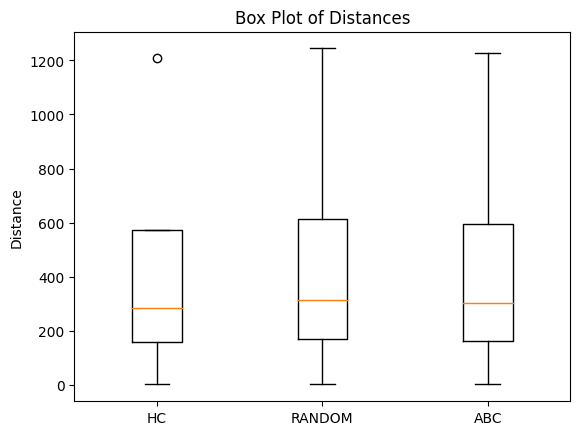

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have lists or arrays for each set of distances
distances_HC = [average_distance_HC, min_distance_HC, max_distance_HC, std_distance_HC]
distances_RANDOM = [average_distance_RANDOM, min_distance_RANDOM, max_distance_RANDOM, std_distance_RANDOM]
distances_ABC = [average_distance_ABC, min_distance_ABC, max_distance_ABC, std_distance_ABC]

# Combine the data into a list of lists
data = [distances_HC, distances_RANDOM, distances_ABC]

# Labels for the box plot
labels = ['HC', 'RANDOM', 'ABC']

# Create a box plot
plt.boxplot(data, labels=labels)
plt.title('Box Plot of Distances')
plt.ylabel('Distance')
plt.show()

## B) Picking Strategie: S-Shape // Picking Method: batch order picking






### **1) AI-driven storage location assignment clustering**

In [ ]:
import pandas as pd
from google.colab import files
# Load the 'hierarchical_cluster_assignments.csv' file
cluster_assignments = df_HC

# Sort the cluster assignments by 'Cluster' column
cluster_assignments = cluster_assignments.sort_values(by='Cluster')

# Calculate the number of items in each cluster
cluster_sizes = cluster_assignments['Cluster'].value_counts()

# Initialize Emplacement counter
emplacement_counter = 1

# Create a new DataFrame to store the results
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Iterate through each cluster
for cluster, size in cluster_sizes.items():
    # Assign Emplacement values from emplacement_counter to emplacement_counter + size - 1
    result_df = pd.concat([result_df, cluster_assignments[cluster_assignments['Cluster'] == cluster]], ignore_index=True)
    result_df.loc[result_df['Cluster'] == cluster, 'Emplacement'] = list(range(emplacement_counter, emplacement_counter + size))

    # Update the Emplacement counter
    emplacement_counter += size
result_df['Items'] = result_df['Items'].str.replace('.csv', '')
# Save the result to a new CSV file
result_df.to_csv('cluster_emplacement_assignments_HC.csv', index=False)

# Download the Excel file to your local machine
files.download('cluster_emplacement_assignments_HC.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd



merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

merged_df.reset_index(drop=True, inplace=True)



<ipython-input-70-fd4c58f67d14>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')


In [ ]:
import os

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_HC'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo' in groups of 6
unique_invoice_nos = merged_df['InvoiceNo'].unique()
grouped_invoice_nos = [unique_invoice_nos[i:i + 6] for i in range(0, len(unique_invoice_nos), 6)]

for group in grouped_invoice_nos:
    # Create a list to store data for the current group
    group_data = []

    # Iterate over 'InvoiceNo' in the current group
    for invoice_no in group:
        # Filter data for the current 'InvoiceNo'
        invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

        # Check if the DataFrame is not empty
        if not invoice_data.empty:
            # Select relevant columns
            invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]
            # Append data to the group_data list
            group_data.append(invoice_csv_data)
        else:
            print(f"No data found for InvoiceNo {invoice_no}")

    # Concatenate data for the current group
    if group_data:
        grouped_csv_data = pd.concat(group_data)

        # Sort by 'Emplacement' in ascending order
        grouped_csv_data.sort_values(by='Emplacement', inplace=True)

        # Save the DataFrame to a CSV file for the current group
        csv_file_path = f"{output_directory}/Invoice_Group_{group[0]}_to_{group[-1]}.csv"
        grouped_csv_data.to_csv(csv_file_path, index=False)

    else:
        pass


In [ ]:
import pandas as pd
import os

# Function to calculate distance between two positions A and Bin warehouse
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        distance = distance_matrix.loc[i, j-1]
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_HC'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_HC= []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances)/6

                # Add the total distance to the list
                distances_list_HC.append(total_distance)

                # Print or use the total distance as needed
                print("processing...")
            else:
                print("done!")

        except Exception as e:
            print(f" processing {csv_file}: {e}. .")

# Calculate the average distance for all valid CSV files
if distances_list_HC:
    average_distance_HC = sum(distances_list_HC) / len(distances_list_HC)
    print(f"Average distance for all valid CSV files: {average_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_HC = min(distances_list_HC)
    max_distance_HC = max(distances_list_HC)
    std_distance_HC = pd.Series(distances_list_HC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_HC}")
    print(f"Maximum distance: {max_distance_HC}")
    print(f"Standard deviation of distances: {std_distance_HC}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
 processing Invoice_557625.csv: 0. .
processing...
 processing Invoice_538170.csv: 0. .
 processing Invoice_552055.csv: 0. .
 processing Invoice_Group_561280_to_561314.csv: 0. .
processing...
processing...
processing...
 processing Invoice_Group_547372_to_547378.csv: 0. .
 processing Invoice_Group_569089_to_569102.csv: 0. .
processing...
 processing Invoice_Group_577409_to_577440.csv: 0. .
processing...
 processing Invoice_Group_574826_to_574833.csv: 0. .
 processing Invoice_569213.csv: 0. .
processing...
processing...
 processing Invoice_539217.csv: 0. .
processing...
processing...
processing...
processing...
processing...
processing...
 processing Invoice_572550.csv: 0. .
processing...
 processing Invoice_555650.csv: 0. .
processing...
processing...
processing...
processing...
 processing Invoice_Group_564953_to_564962.csv: 0. .
done!
 processing Invoice_570501.csv: 0. .
done!
 processing Invoice_574963.csv: 0. .
processing...
 proce

In [ ]:
# Calculate the average distance for all valid CSV files
if distances_list_HC:
    average_distance_HC = sum(distances_list_HC) / len(distances_list_HC)
    print(f"Average distance for all valid CSV files: {average_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_HC = min(distances_list_HC)
    max_distance_HC = max(distances_list_HC)
    std_distance_HC = pd.Series(distances_list_HC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_HC}")
    print(f"Maximum distance: {max_distance_HC}")
    print(f"Standard deviation of distances: {std_distance_HC}")
else:
    print("No valid CSV files found.")

Average distance for all valid CSV files: 63.841905156919644
Minimum distance (excluding 0s): 0.3333333333333333
Maximum distance: 243.0
Standard deviation of distances: 39.10311202060238


### **2) Random Storage**

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [ ]:
import random
# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Assign values to result_df
for csv_file in mydataset:
    # Extract item name from the CSV file path
    item_name = csv_file.replace('.csv', '')

    # Assign values to the DataFrame
    result_df = result_df.append({
        'Items': item_name,
        'Cluster': 1,
        'Emplacement': random.randint(1, 788)}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('result_df.csv', index=False)


In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)



<ipython-input-79-b9e9f1e277a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')


In [ ]:

import os

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_RANDOM2'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo' in groups of 6
unique_invoice_nos = merged_df['InvoiceNo'].unique()
grouped_invoice_nos = [unique_invoice_nos[i:i + 6] for i in range(0, len(unique_invoice_nos), 6)]

for group in grouped_invoice_nos:
    # Create a list to store data for the current group
    group_data = []

    # Iterate over 'InvoiceNo' in the current group
    for invoice_no in group:
        # Filter data for the current 'InvoiceNo'
        invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

        # Check if the DataFrame is not empty
        if not invoice_data.empty:
            # Select relevant columns
            invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]
            # Append data to the group_data list
            group_data.append(invoice_csv_data)
        else:
            print(f"No data found for InvoiceNo {invoice_no}")

    # Concatenate data for the current group
    if group_data:
        grouped_csv_data = pd.concat(group_data)

        # Sort by 'Emplacement' in ascending order
        grouped_csv_data.sort_values(by='Emplacement', inplace=True)

        # Save the DataFrame to a CSV file for the current group
        csv_file_path = f"{output_directory}/Invoice_Group_{group[0]}_to_{group[-1]}.csv"
        grouped_csv_data.to_csv(csv_file_path, index=False)

    else:
        pass


In [ ]:
import pandas as pd
import os

# Function to calculate distance between two positions A and B
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        distance = distance_matrix.loc[i, j-1]
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_RANDOM2'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_RANDOM = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances)/6

                # Add the total distance to the list
                distances_list_RANDOM.append(total_distance)

                # Print or use the total distance as needed
                print(f" {csv_file}: {total_distance}")
            else:
                print(f"Done {csv_file}")

        except Exception as e:
            print(f"done ")
# Calculate the average distance for all valid CSV files
if distances_list_RANDOM:
    average_distance_RANDOM = sum(distances_list_RANDOM) / len(distances_list_RANDOM)
    print(f"Average distance for all valid CSV files: {average_distance_RANDOM}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_RANDOM = min(distances_list_RANDOM)
    max_distance_RANDOM = max(distances_list_RANDOM)
    std_distance_RANDOM = pd.Series(distances_list_RANDOM).std()

    print(f"Minimum distance (excluding 0s): {min_distance_RANDOM}")
    print(f"Maximum distance: {max_distance_RANDOM}")
    print(f"Standard deviation of distances: {std_distance_RANDOM}")
else:
    print("No valid CSV files found.")


done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
 Invoice_Group_578683_to_578688.csv: 172.33333333333334
done 
done 
done 
done 
done 
done 
 Invoice_Group_576628_to_576634.csv: 170.66666666666666
done 
done 
done 
done 
done 
done 
 Invoice_Group_561806_to_561814.csv: 162.0
done 
done 
done 
done 
done 
 Invoice_Group_578429_to_578456.csv: 193.0
done 
done 
done 
done 
done 
done 
 Invoice_Group_559346_to_559355.csv: 162.66666666666666
done 
done 
 Invoice_Group_563328_to_563348.csv: 163.66666666666666
 Invoice_Group_576601_to_576606.csv: 176.0
done 
done 
 Invoice_Group_578293_to_578298.csv: 169.33333333333334
done 
done 
 Invoice_Group_564043_to_564049.csv: 189.66666666666666
done 
done 
 Invoice_Group_542137_to_542148.csv: 115.33333333333333
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
 Invoice_Group_577595_to_577600.csv: 196.0
done 
done 
done 
 Invoice_Group_574833_to_574838.csv: 188.0
done 
done 
done 
 Invoice_Group_543604_to_54

In [ ]:
# Calculate the average distance for all valid CSV files
if distances_list_RANDOM:
    average_distance_RANDOM = sum(distances_list_RANDOM) / len(distances_list_RANDOM)
    print(f"Average distance for all valid CSV files: {average_distance_RANDOM}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_RANDOM = min(distances_list_RANDOM)
    max_distance_RANDOM = max(distances_list_RANDOM)
    std_distance_RANDOM = pd.Series(distances_list_RANDOM).std()

    print(f"Minimum distance (excluding 0s): {min_distance_RANDOM}")
    print(f"Maximum distance: {max_distance_RANDOM}")
    print(f"Standard deviation of distances: {std_distance_RANDOM}")
else:
    print("No valid CSV files found.")

Average distance for all valid CSV files: 157.17058823529413
Minimum distance (excluding 0s): 57.0
Maximum distance: 220.0
Standard deviation of distances: 28.340938265994936


### **3) old school ABC Classification**

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
import pandas as pd
import random

# Function to get the frequency of items in invoiceno
def get_invoice_frequency(csv_file):
    # Replace this with your actual code to calculate frequency
    # Example: Read the CSV file and count unique invoicenos
    df = data
    return len(df['InvoiceNo'].unique())

# Calculate the frequency of each item in mydataset
item_frequencies = {}

for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')
    frequency = get_invoice_frequency(csv_file)
    item_frequencies[item_name] = frequency

# Sort items by frequency in descending order
sorted_items = sorted(item_frequencies.items(), key=lambda x: x[1], reverse=True)

# Extract top 190 items and most frequent 380 items
top_190_items = [item[0] for item in sorted_items[:190]]
most_frequent_380_items = [item[0] for item in sorted_items[190:570]]

# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster'])

# Assign ABC class based on your criteria
for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')

    if item_name in top_190_items:
        abc_class = 'A'
    elif item_name in most_frequent_380_items:
        abc_class = 'B'
    else:
        abc_class = 'C'

    result_df = result_df.append({'Items': item_name, 'Cluster': abc_class}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('ABC_classification.csv', index=False)



In [ ]:
# Update the result_df DataFrame with the 'Emplacement' column successively
result_df['Emplacement'] = list(range(1, len(result_df) + 1))

# Save the updated result_df to a new CSV file
result_df.to_csv('ABC_classification_with_Successive_Emplacement.csv', index=False)



In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

# Convert 'Emplacement' column to integers and format it
merged_df['Emplacement'] = merged_df['Emplacement'].fillna(0).astype(int).astype(str)


'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)



In [ ]:
import os

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_ABC_class'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo' in groups of 6
unique_invoice_nos = merged_df['InvoiceNo'].unique()
grouped_invoice_nos = [unique_invoice_nos[i:i + 6] for i in range(0, len(unique_invoice_nos), 6)]

for group in grouped_invoice_nos:
    # Create a list to store data for the current group
    group_data = []

    # Iterate over 'InvoiceNo' in the current group
    for invoice_no in group:
        # Filter data for the current 'InvoiceNo'
        invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

        # Check if the DataFrame is not empty
        if not invoice_data.empty:
            # Select relevant columns
            invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]
            # Append data to the group_data list
            group_data.append(invoice_csv_data)
        else:
            print(f"No data found for InvoiceNo {invoice_no}")

    # Concatenate data for the current group
    if group_data:
        grouped_csv_data = pd.concat(group_data)

        # Sort by 'Emplacement' in ascending order
        grouped_csv_data.sort_values(by='Emplacement', inplace=True)

        # Save the DataFrame to a CSV file for the current group
        csv_file_path = f"{output_directory}/Invoice_Group_{group[0]}_to_{group[-1]}.csv"
        grouped_csv_data.to_csv(csv_file_path, index=False)

    else:
        pass



In [ ]:
import pandas as pd
import os

# Function to calculate distance between two positions A and B
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        distance = distance_matrix.loc[i, j-1]
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_ABC_class'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_ABC = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances)/6

                # Add the total distance to the list
                distances_list_ABC.append(total_distance)

                # Print or use the total distance as needed
                print("processing...")
            else:
                print("done!")

        except Exception as e:
            print(f" processing {csv_file}: {e}. .")

# Calculate the average distance for all valid CSV files
if distances_list_ABC:
    average_distance_ABC = sum(distances_list_ABC) / len(distances_list_ABC)
    print(f"Average distance for all valid CSV files: {average_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_ABC = min(distances_list_ABC)
    max_distance_ABC = max(distances_list_ABC)
    std_distance_ABC = pd.Series(distances_list_ABC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_ABC}")
    print(f"Maximum distance: {max_distance_ABC}")
    print(f"Standard deviation of distances: {std_distance_ABC}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
processing...
 processing Invoice_Group_555264_to_555277.csv: 0. .
processing...
 processing Invoice_Group_559940_to_559951.csv: 0. .
done!
processing...
 processing Invoice_540832.csv: 0. .
processing...
processing...
processing...
done!
processing...
 processing Invoice_Group_541968_to_541973.csv: 0. .
 processing Invoice_564733.csv: 0. .
 processing Invoice_568991.csv: 0. .
processing...
processing...
 processing Invoice_Group_569036_to_569078.csv: 0. .
processing...
processing...
processing...
 processing Invoice_Group_564150_to_564162.csv: 0. .
processing...
processing...
 processing Invoice_564150.csv: 0. .
processing...
 processing Invoice_578250.csv: 0. .
 processing Invoice_557020.csv: 0. .
processing...
 processing Invoice_Group_549694_to_549714.csv: 0. .
processing...
processing...
processing...
processing...
processing...
processing...
processing...
processing...
done!
 processing Invoice_558751.csv: 0. .
processing...
done

In [ ]:
if distances_list_ABC:
    average_distance_ABC = sum(distances_list_ABC) / len(distances_list_ABC)
    print(f"Average distance ABC: {average_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_ABC = min(distances_list_ABC)
    max_distance_ABC = max(distances_list_ABC)
    std_distance_ABC = pd.Series(distances_list_ABC).std()

    print(f"Minimum distance ABC: {min_distance_ABC}")
    print(f"Maximum distance ABC: {max_distance_ABC}")
    print(f"Standard deviation ABC: {std_distance_ABC}")
else:
    print("No valid CSV files found.")


Average distance ABC: 68.64358917643581
Minimum distance ABC: 0.3333333333333333
Maximum distance ABC: 224.66666666666666
Standard deviation ABC: 40.597103057599696


In [ ]:
print(f"Average distance HC:",average_distance_HC)
print(f"Minimum distance HC: {min_distance_HC}")
print(f"Maximum distance HC: {max_distance_HC}")
print(f"Standard deviation of distances HC: {std_distance_HC}")
print(f"Average distance RADNOM:",average_distance_RANDOM)
print(f"Minimum distance RANDOM: {min_distance_RANDOM}")
print(f"Maximum distance RANDOM: {max_distance_RANDOM}")
print(f"Standard deviation RANDOM: {std_distance_RANDOM}")
print(f"Average distance ABC:",average_distance_ABC)
print(f"Minimum distance ABC: {min_distance_ABC}")
print(f"Maximum distance ABC: {max_distance_ABC}")
print(f"Standard deviation ABC: {std_distance_ABC}")

Average distance HC: 63.841905156919644
Minimum distance HC: 0.3333333333333333
Maximum distance HC: 243.0
Standard deviation of distances HC: 39.10311202060238
Average distance RADNOM: 157.17058823529413
Minimum distance RANDOM: 57.0
Maximum distance RANDOM: 220.0
Standard deviation RANDOM: 28.340938265994936
Average distance ABC: 68.64358917643581
Minimum distance ABC: 0.3333333333333333
Maximum distance ABC: 224.66666666666666
Standard deviation ABC: 40.597103057599696


Summary and Anova test

In [ ]:
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Ensure all lists have the same length
min_length = min(len(distances_list_ABC), len(distances_list_HC), len(distances_list_RANDOM))

# Trim the lists to the minimum length
distances_list_ABC = distances_list_ABC[:min_length]
distances_list_HC = distances_list_HC[:min_length]
distances_list_RANDOM = distances_list_RANDOM[:min_length]


# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': distances_list_ABC,
    'HC': distances_list_HC,
    'RANDOM': distances_list_RANDOM,
})

# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': distances_list_ABC,
    'HC': distances_list_HC,
    'RANDOM': distances_list_RANDOM,
})

# Perform One-Way ANOVA
anova_result = f_oneway(
    data['ABC'],
    data['HC'],
    data['RANDOM'],
)

# Display the ANOVA result
print("One-way ANOVA p-value:", anova_result.pvalue)

# Perform Tukey's test for multiple comparisons (post hoc analysis)
flattened_data = np.concatenate([data['ABC'], data['HC'], data['RANDOM']])
labels = np.concatenate([['ABC'] * len(data['ABC']), ['HC'] * len(data['HC']), ['RANDOM'] * len(data['RANDOM']) ])

tukey_result = pairwise_tukeyhsd(flattened_data, labels)

# Display the Tukey's test results
print(tukey_result)

# Additional Statistics
mean_distances = data.mean()
std_distances = data.std()

# Display the mean and standard deviation for each group
print("\nMean distances:")
print(mean_distances)
print("\nStandard deviation distances:")
print(std_distances)


One-way ANOVA p-value: 7.989247330097096e-288
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   ABC     HC     -2.9 0.4028 -8.1871  2.3871  False
   ABC RANDOM  88.0118    0.0 82.7246 93.2989   True
    HC RANDOM  90.9118    0.0 85.6246 96.1989   True
----------------------------------------------------

Mean distances:
ABC        69.158824
HC         66.258824
RANDOM    157.170588
dtype: float64

Standard deviation distances:
ABC       38.114366
HC        40.368037
RANDOM    28.340938
dtype: float64


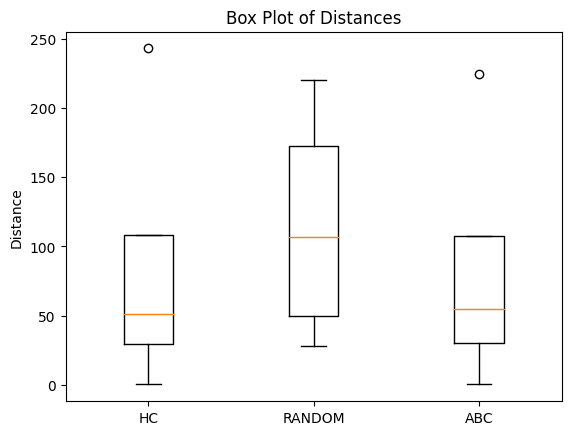

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have lists or arrays for each set of distances
distances_HC = [average_distance_HC, min_distance_HC, max_distance_HC, std_distance_HC]
distances_RANDOM = [average_distance_RANDOM, min_distance_RANDOM, max_distance_RANDOM, std_distance_RANDOM]
distances_ABC = [average_distance_ABC, min_distance_ABC, max_distance_ABC, std_distance_ABC]

# Combine the data into a list of lists
data = [distances_HC, distances_RANDOM, distances_ABC]

# Labels for the box plot
labels = ['HC', 'RANDOM', 'ABC']

# Create a box plot
plt.boxplot(data, labels=labels)
plt.title('Box Plot of Distances')
plt.ylabel('Distance')
plt.show()

## C) Picking Strategie: S-Shape // Picking Method: Zone order picking




### **1) AI-driven storage location assignment clustering**

In [ ]:
import pandas as pd
from google.colab import files
# Load the 'hierarchical_cluster_assignments.csv' file
cluster_assignments = df_HC

# Sort the cluster assignments by 'Cluster' column
cluster_assignments = cluster_assignments.sort_values(by='Cluster')

# Calculate the number of items in each cluster
cluster_sizes = cluster_assignments['Cluster'].value_counts()

# Initialize Emplacement counter
emplacement_counter = 1

# Create a new DataFrame to store the results
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Iterate through each cluster
for cluster, size in cluster_sizes.items():
    # Assign Emplacement values from emplacement_counter to emplacement_counter + size - 1
    result_df = pd.concat([result_df, cluster_assignments[cluster_assignments['Cluster'] == cluster]], ignore_index=True)
    result_df.loc[result_df['Cluster'] == cluster, 'Emplacement'] = list(range(emplacement_counter, emplacement_counter + size))

    # Update the Emplacement counter
    emplacement_counter += size
result_df['Items'] = result_df['Items'].str.replace('.csv', '')
# Save the result to a new CSV file
result_df.to_csv('cluster_emplacement_assignments_HC.csv', index=False)

# Download the Excel file to your local machine
files.download('cluster_emplacement_assignments_HC.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd



merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

merged_df.reset_index(drop=True, inplace=True)


<ipython-input-101-5acb52240e25>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')


In [ ]:

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_HC'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo'
for invoice_no in merged_df['InvoiceNo'].unique():
    # Filter data for the current 'InvoiceNo'
    invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

    # Check if the DataFrame is not empty
    if not invoice_data.empty:
        # Select relevant columns
        invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]

        # Save the DataFrame to a CSV file
        csv_file_path = f"{output_directory}/Invoice_{invoice_no}.csv"
        invoice_csv_data.to_csv(csv_file_path, index=False)

    else:
        pass


In [ ]:
import os
import pandas as pd

# Define or import the calculate_distance function and distance_matrix variable

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_HC'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store total distances for each valid CSV file
total_distances_list_HC = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Initialize total distance for the current CSV file
            total_distance = 0

            # Iterate over unique clusters in the DataFrame
            for cluster in df['Cluster'].unique():
                # Filter data for the current cluster
                cluster_data = df[df['Cluster'] == cluster]

                # Calculate distances between consecutive 'Emplacement' values for the current cluster
                distances = [calculate_distance(cluster_data['Emplacement'].iloc[i],
                                                cluster_data['Emplacement'].iloc[i + 1],
                                                distance_matrix)
                             for i in range(len(cluster_data) - 1)]

                # Sum the distances for the current cluster
                cluster_total_distance = sum(distances)

                # Add the cluster distance to the total distance for the CSV file
                total_distance += cluster_total_distance

                # Print or use the cluster distance as needed
                print(f"Distance for Cluster {cluster} in {csv_file}: {cluster_total_distance}")

            # Add the total distance for the CSV file to the list
            total_distances_list_HC.append(total_distance)

            # Print or use the total distance for the CSV file as needed
            print(f"Total distance for {csv_file}: {total_distance}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average total distance for all valid CSV files
if total_distances_list_HC:
    average_total_distance_HC = sum(total_distances_list_HC) / len(total_distances_list_HC)
    print(f"Average total distance for all valid CSV files: {average_total_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_HC = min(total_distances_list_HC)
    max_total_distance_HC = max(total_distances_list_HC)
    std_total_distance_HC = pd.Series(total_distances_list_HC).std()

    print(f"Minimum total distance: {min_total_distance_HC}")
    print(f"Maximum total distance: {max_total_distance_HC}")
    print(f"Standard deviation of total distances: {std_total_distance_HC}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
Distance for Cluster 4 in Invoice_581327.csv: 0
Total distance for Invoice_581327.csv: 28
Error processing Invoice_575607.csv: 0. Skipping to the next CSV.
Distance for Cluster 6 in Invoice_539403.csv: 54
Distance for Cluster 2 in Invoice_539403.csv: 0
Distance for Cluster 7 in Invoice_539403.csv: 0
Total distance for Invoice_539403.csv: 54
Distance for Cluster 0 in Invoice_555852.csv: 34
Distance for Cluster 9 in Invoice_555852.csv: 0
Distance for Cluster 11 in Invoice_555852.csv: 0
Distance for Cluster 2 in Invoice_555852.csv: 4
Distance for Cluster 4 in Invoice_555852.csv: 0
Total distance for Invoice_555852.csv: 38
Distance for Cluster 11 in Invoice_539328.csv: 0
Distance for Cluster 2 in Invoice_539328.csv: 0
Total distance for Invoice_539328.csv: 0
Distance for Cluster 9 in Invoice_546768.csv: 0
Distance for Cluster 1 in Invoice_546768.csv: 0
Distance for Cluster 8 in Invoice_546768.csv: 0
Total distance for Invoice_546768.csv: 0

In [ ]:
# Calculate the average distance for all clusters in valid CSV files
if total_distances_list_HC:
    average_total_distance_HC = sum(total_distances_list_HC) / len(total_distances_list_HC)
    print(f"Average total distance for all clusters in valid CSV files: {average_total_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_HC = min(total_distances_list_HC)
    max_total_distance_HC = max(total_distances_list_HC)
    std_total_distance_HC = pd.Series(total_distances_list_HC).std()

    print(f"Minimum total distance: {min_total_distance_HC}")
    print(f"Maximum total distance: {max_total_distance_HC}")
    print(f"Standard deviation of total distances: {std_total_distance_HC}")
else:
    print("No valid CSV files found.")


Average total distance for all clusters in valid CSV files: 133.6612407862408
Minimum total distance: 0
Maximum total distance: 1264
Standard deviation of total distances: 179.95301865212755


### **2) Random Storage**

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [ ]:
import random
# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Assign values to result_df
for csv_file in mydataset:
    # Extract item name from the CSV file path
    item_name = csv_file.replace('.csv', '')

    # Assign values to the DataFrame
    result_df = result_df.append({
        'Items': item_name,
        'Cluster': 1,
        'Emplacement': random.randint(1, 788)}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('result_df.csv', index=False)



In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)



<ipython-input-110-b9e9f1e277a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')
<ipython-input-110-b9e9f1e277a5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)


In [ ]:

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_RANDOM'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo'
for invoice_no in merged_df['InvoiceNo'].unique():
    # Filter data for the current 'InvoiceNo'
    invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

    # Check if the DataFrame is not empty
    if not invoice_data.empty:
        # Select relevant columns
        invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]

        # Save the DataFrame to a CSV file
        csv_file_path = f"{output_directory}/Invoice_{invoice_no}.csv"
        invoice_csv_data.to_csv(csv_file_path, index=False)

    else:
        pass


In [ ]:


import os
import pandas as pd

# Define or import the calculate_distance function and distance_matrix variable

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_RANDOM'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store total distances for each valid CSV file
total_distances_list_RANDOM = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Initialize total distance for the current CSV file
            total_distance = 0

            # Iterate over unique clusters in the DataFrame
            for cluster in df['Cluster'].unique():
                # Filter data for the current cluster
                cluster_data = df[df['Cluster'] == cluster]

                # Calculate distances between consecutive 'Emplacement' values for the current cluster
                distances = [calculate_distance(cluster_data['Emplacement'].iloc[i],
                                                cluster_data['Emplacement'].iloc[i + 1],
                                                distance_matrix)
                             for i in range(len(cluster_data) - 1)]

                # Sum the distances for the current cluster
                cluster_total_distance = sum(distances)

                # Add the cluster distance to the total distance for the CSV file
                total_distance += cluster_total_distance

                # Print or use the cluster distance as needed
                print(f"Distance for Cluster {cluster} in {csv_file}: {cluster_total_distance}")

            # Add the total distance for the CSV file to the list
            total_distances_list_RANDOM.append(total_distance)

            # Print or use the total distance for the CSV file as needed
            print(f"Total distance for {csv_file}: {total_distance}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average total distance for all valid CSV files
if total_distances_list_RANDOM:
    average_total_distance_RANDOM = sum(total_distances_list_RANDOM) / len(total_distances_list_RANDOM)
    print(f"Average total distance for all valid CSV files: {average_total_distance_RANDOM}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_RANDOM = min(total_distances_list_RANDOM)
    max_total_distance_RANDOM = max(total_distances_list_RANDOM)
    std_total_distance_RANDOM = pd.Series(total_distances_list_RANDOM).std()

    print(f"Minimum total distance: {min_total_distance_RANDOM}")
    print(f"Maximum total distance: {max_total_distance_RANDOM}")
    print(f"Standard deviation of total distances: {std_total_distance_RANDOM}")
else:
    print("No valid CSV files found.")



Streaming output truncated to the last 5000 lines.
Error processing Invoice_568984.csv: 0. Skipping to the next CSV.
Distance for Cluster 1 in Invoice_575966.csv: 204
Total distance for Invoice_575966.csv: 204
Distance for Cluster 1 in Invoice_541837.csv: 30
Total distance for Invoice_541837.csv: 30
Distance for Cluster 1 in Invoice_576099.csv: 462
Total distance for Invoice_576099.csv: 462
Distance for Cluster 1 in Invoice_559048.csv: 148
Total distance for Invoice_559048.csv: 148
Error processing Invoice_568161.csv: 0. Skipping to the next CSV.
Error processing Invoice_573174.csv: 0. Skipping to the next CSV.
Distance for Cluster 1 in Invoice_543788.csv: 0
Total distance for Invoice_543788.csv: 0
Distance for Cluster 1 in Invoice_563257.csv: 420
Total distance for Invoice_563257.csv: 420
Distance for Cluster 1 in Invoice_571566.csv: 580
Total distance for Invoice_571566.csv: 580
Error processing Invoice_546534.csv: 0. Skipping to the next CSV.
Distance for Cluster 1 in Invoice_561705

In [ ]:
# Calculate the average total distance for all valid CSV files
if total_distances_list_RANDOM:
    average_total_distance_RANDOM = sum(total_distances_list_RANDOM) / len(total_distances_list_RANDOM)
    print(f"Average total distance for all valid CSV files: {average_total_distance_RANDOM}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_RANDOM = min(total_distances_list_RANDOM)
    max_total_distance_RANDOM = max(total_distances_list_RANDOM)
    std_total_distance_RANDOM = pd.Series(total_distances_list_RANDOM).std()

    print(f"Minimum total distance: {min_total_distance_RANDOM}")
    print(f"Maximum total distance: {max_total_distance_RANDOM}")
    print(f"Standard deviation of total distances: {std_total_distance_RANDOM}")
else:
    print("No valid CSV files found.")

Average total distance for all valid CSV files: 348.4752502399561
Minimum total distance: 0
Maximum total distance: 1254
Standard deviation of total distances: 244.8536455766295


### **3) old school ABC Classification**

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
import pandas as pd
import random

# Function to get the frequency of items in invoiceno
def get_invoice_frequency(csv_file):
    # Replace this with your actual code to calculate frequency
    # Example: Read the CSV file and count unique invoicenos
    df = data
    return len(df['InvoiceNo'].unique())

# Calculate the frequency of each item in mydataset
item_frequencies = {}

for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')
    frequency = get_invoice_frequency(csv_file)
    item_frequencies[item_name] = frequency

# Sort items by frequency in descending order
sorted_items = sorted(item_frequencies.items(), key=lambda x: x[1], reverse=True)

# Extract top 190 items and most frequent 380 items
top_190_items = [item[0] for item in sorted_items[:190]]
most_frequent_380_items = [item[0] for item in sorted_items[190:570]]

# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster'])

# Assign ABC class based on your criteria
for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')

    if item_name in top_190_items:
        abc_class = 'A'
    elif item_name in most_frequent_380_items:
        abc_class = 'B'
    else:
        abc_class = 'C'

    result_df = result_df.append({'Items': item_name, 'Cluster': abc_class}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('ABC_classification.csv', index=False)




In [ ]:
# Update the result_df DataFrame with the 'Emplacement' column successively
result_df['Emplacement'] = list(range(1, len(result_df) + 1))

# Save the updated result_df to a new CSV file
result_df.to_csv('ABC_classification_with_Successive_Emplacement.csv', index=False)



In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

# Convert 'Emplacement' column to integers and format it
merged_df['Emplacement'] = merged_df['Emplacement'].fillna(0).astype(int).astype(str)


'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)


In [ ]:

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_ABC_class1'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo'
for invoice_no in merged_df['InvoiceNo'].unique():
    # Filter data for the current 'InvoiceNo'
    invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

    # Check if the DataFrame is not empty
    if not invoice_data.empty:
        # Select relevant columns
        invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]

        # Save the DataFrame to a CSV file
        csv_file_path = f"{output_directory}/Invoice_{invoice_no}.csv"
        invoice_csv_data.to_csv(csv_file_path, index=False)

    else:
        pass


In [ ]:
import pandas as pd
import os

# Function to calculate distance between two positions A and B
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        distance = distance_matrix.loc[i, j-1]
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files_ABC_class' directory
csv_directory = 'invoice_csv_files_ABC_class1'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store total distances for each valid CSV file
total_distances_list_ABC = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Initialize total distance for the current CSV file
            total_distance = 0

            # Iterate over unique clusters in the DataFrame
            for cluster in df['Cluster'].unique():
                # Filter data for the current cluster
                cluster_data = df[df['Cluster'] == cluster]

                # Calculate distances between consecutive 'Emplacement' values for the current cluster
                distances = [calculate_distance(cluster_data['Emplacement'].iloc[i],
                                                cluster_data['Emplacement'].iloc[i + 1],
                                                distance_matrix)
                             for i in range(len(cluster_data) - 1)]

                # Sum the distances for the current cluster
                cluster_total_distance = sum(distances)

                # Add the cluster distance to the total distance for the CSV file
                total_distance += cluster_total_distance

                # Print or use the cluster distance as needed
                print(f"Distance for Cluster {cluster} in {csv_file}: {cluster_total_distance}")

            # Add the total distance for the CSV file to the list
            total_distances_list_ABC.append(total_distance)

            # Print or use the total distance for the CSV file as needed
            print(f"Total distance for {csv_file}: {total_distance}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average total distance for all valid CSV files
if total_distances_list_ABC:
    average_total_distance_ABC = sum(total_distances_list_ABC) / len(total_distances_list_ABC)
    print(f"Average total distance for all valid CSV files: {average_total_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_ABC = min(total_distances_list_ABC)
    max_total_distance_ABC = max(total_distances_list_ABC)
    std_total_distance_ABC = pd.Series(total_distances_list_ABC).std()

    print(f"Minimum total distance: {min_total_distance_ABC}")
    print(f"Maximum total distance: {max_total_distance_ABC}")
    print(f"Standard deviation of total distances: {std_total_distance_ABC}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
Distance for Cluster B in Invoice_566709.csv: 74
Total distance for Invoice_566709.csv: 292
Distance for Cluster A in Invoice_566422.csv: 56
Distance for Cluster B in Invoice_566422.csv: 0
Distance for Cluster C in Invoice_566422.csv: 28
Total distance for Invoice_566422.csv: 84
Distance for Cluster A in Invoice_558641.csv: 112
Distance for Cluster B in Invoice_558641.csv: 260
Distance for Cluster C in Invoice_558641.csv: 96
Total distance for Invoice_558641.csv: 468
Distance for Cluster A in Invoice_547894.csv: 92
Distance for Cluster B in Invoice_547894.csv: 38
Total distance for Invoice_547894.csv: 130
Error processing Invoice_569238.csv: 0. Skipping to the next CSV.
Distance for Cluster A in Invoice_555849.csv: 42
Distance for Cluster B in Invoice_555849.csv: 238
Total distance for Invoice_555849.csv: 280
Distance for Cluster A in Invoice_553879.csv: 268
Distance for Cluster B in Invoice_553879.csv: 376
Distance for Cluster C in In

In [ ]:
# Calculate the average total distance for all valid CSV files
if total_distances_list_ABC:
    average_total_distance_ABC = sum(total_distances_list_ABC) / len(total_distances_list_ABC)
    print(f"Average total distance for all valid CSV files: {average_total_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_ABC = min(total_distances_list_ABC)
    max_total_distance_ABC = max(total_distances_list_ABC)
    std_total_distance_ABC = pd.Series(total_distances_list_ABC).std()

    print(f"Minimum total distance: {min_total_distance_ABC}")
    print(f"Maximum total distance: {max_total_distance_ABC}")
    print(f"Standard deviation of total distances: {std_total_distance_ABC}")
else:
    print("No valid CSV files found.")


Average total distance for all valid CSV files: 244.34597776324395
Minimum total distance: 0
Maximum total distance: 1196
Standard deviation of total distances: 221.72529505502976


Summary and Anova test

In [ ]:
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Ensure all lists have the same length
min_length = min(len(total_distances_list_ABC), len(total_distances_list_HC), len(total_distances_list_RANDOM))

# Trim the lists to the minimum length
total_distances_list_ABC = total_distances_list_ABC[:min_length]
total_distances_list_HC = total_distances_list_HC[:min_length]
total_distances_list_RANDOM = total_distances_list_RANDOM[:min_length]


# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': total_distances_list_ABC,
    'HC': total_distances_list_HC,
    'RANDOM': total_distances_list_RANDOM,
})

# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': total_distances_list_ABC,
    'HC': total_distances_list_HC,
    'RANDOM': total_distances_list_RANDOM,
})

# Perform One-Way ANOVA
anova_result = f_oneway(
    data['ABC'],
    data['HC'],
    data['RANDOM'],
)

# Display the ANOVA result
print("One-way ANOVA p-value:", anova_result.pvalue)

# Perform Tukey's test for multiple comparisons (post hoc analysis)
flattened_data = np.concatenate([data['ABC'], data['HC'], data['RANDOM']])
labels = np.concatenate([['ABC'] * len(data['ABC']), ['HC'] * len(data['HC']), ['RANDOM'] * len(data['RANDOM']) ])

tukey_result = pairwise_tukeyhsd(flattened_data, labels)

# Display the Tukey's test results
print(tukey_result)

# Additional Statistics
mean_distances = data.mean()
std_distances = data.std()

# Display the mean and standard deviation for each group
print("\nMean distances:")
print(mean_distances)
print("\nStandard deviation distances:")
print(std_distances)


One-way ANOVA p-value: 0.0
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
   ABC     HC -110.9345   0.0 -116.9038 -104.9651   True
   ABC RANDOM  103.7156   0.0   97.7462   109.685   True
    HC RANDOM  214.6501   0.0  208.6807  220.6195   True
--------------------------------------------------------

Mean distances:
ABC       244.759633
HC        133.825175
RANDOM    348.475250
dtype: float64

Standard deviation distances:
ABC       222.324257
HC        180.393744
RANDOM    244.853646
dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have lists or arrays for each set of distances
distances_HC = [average_total_distance_HC, min_total_distance_HC, max_total_distance_HC, std_total_distance_HC]
distances_RANDOM = [average_total_distance_RANDOM, min_total_distance_RANDOM, max_total_distance_RANDOM, std_total_distance_RANDOM]
distances_ABC = [average_total_distance_ABC, min_total_distance_ABC, max_total_distance_ABC, std_total_distance_ABC]

# Combine the data into a list of lists
data = [distances_HC, distances_RANDOM, distances_ABC]

# Labels for the box plot
labels = ['HC', 'RANDOM', 'ABC']

# Create a box plot
plt.boxplot(data, labels=labels)
plt.title('Box Plot of Distances')
plt.ylabel('Distance')
plt.show()

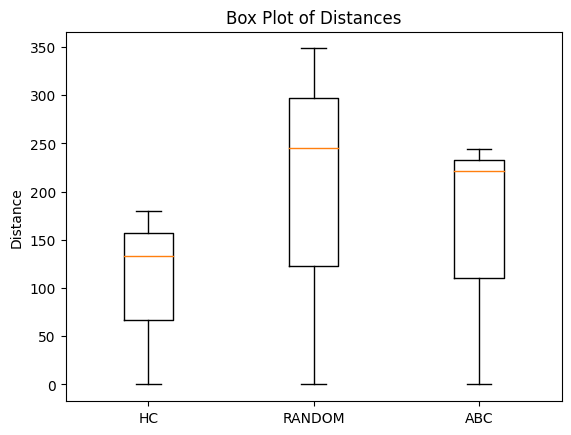

In [ ]:
import matplotlib.pyplot as plt

# Updated data
average_distance_HC = 133.6612407862408
min_distance_HC = 0
max_distance_HC = 1264
std_distance_HC = 179.95301865212755

average_distance_RANDOM = 348.4752502399561
min_distance_RANDOM = 0
max_distance_RANDOM = 1254
std_distance_RANDOM = 244.8536455766295

average_distance_ABC = 244.34597776324395
min_distance_ABC = 0
max_distance_ABC = 1196
std_distance_ABC = 221.72529505502976

# Combine the data into lists
distances_HC = [average_distance_HC, min_distance_HC, std_distance_HC]
distances_RANDOM = [average_distance_RANDOM, min_distance_RANDOM, std_distance_RANDOM]
distances_ABC = [average_distance_ABC, min_distance_ABC, std_distance_ABC]

# Combine the data into a list of lists
data = [distances_HC, distances_RANDOM, distances_ABC]

# Labels for the box plot
labels = ['HC', 'RANDOM', 'ABC']

# Create a box plot
plt.boxplot(data, labels=labels)
plt.title('Box Plot of Distances')
plt.ylabel('Distance')
plt.show()


## D) Picking Strategie: mid-Point/ Picking Method: single picker






### **1) AI-driven storage location assignment clustering**

In [ ]:
import pandas as pd
from google.colab import files
# Load the 'hierarchical_cluster_assignments.csv' file
cluster_assignments = df_HC

# Sort the cluster assignments by 'Cluster' column
cluster_assignments = cluster_assignments.sort_values(by='Cluster')

# Calculate the number of items in each cluster
cluster_sizes = cluster_assignments['Cluster'].value_counts()

# Initialize Emplacement counter
emplacement_counter = 1

# Create a new DataFrame to store the results
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Iterate through each cluster
for cluster, size in cluster_sizes.items():
    # Assign Emplacement values from emplacement_counter to emplacement_counter + size - 1
    result_df = pd.concat([result_df, cluster_assignments[cluster_assignments['Cluster'] == cluster]], ignore_index=True)
    result_df.loc[result_df['Cluster'] == cluster, 'Emplacement'] = list(range(emplacement_counter, emplacement_counter + size))

    # Update the Emplacement counter
    emplacement_counter += size
result_df['Items'] = result_df['Items'].str.replace('.csv', '')
# Save the result to a new CSV file
result_df.to_csv('cluster_emplacement_assignments_HC.csv', index=False)

# Download the Excel file to your local machine
files.download('cluster_emplacement_assignments_HC.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd



merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

merged_df.reset_index(drop=True, inplace=True)



<ipython-input-33-fd4c58f67d14>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')
<ipython-input-33-fd4c58f67d14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)


In [ ]:
import pandas as pd
import os

# Function to determine if an emplacement is in the front or rear aisle
def determine_aisle(emplacement):
    i = emplacement - (emplacement // 40) * 40
    return 1 if (0 <= i <= 10) or (31 <= i <= 40) else 0

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_HC'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo'
for invoice_no in merged_df['InvoiceNo'].unique():
    # Filter data for the current 'InvoiceNo'
    invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

    # Check if the DataFrame is not empty
    if not invoice_data.empty:
        # Select relevant columns
        invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]

        # Create a new column 'front/rear aisle' and fill it based on the conditions
        invoice_csv_data['front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)

        # Save the DataFrame to a CSV file
        csv_file_path = f"{output_directory}/Invoice_{invoice_no}.csv"
        invoice_csv_data.to_csv(csv_file_path, index=False)

    else:
        pass

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_csv_data['front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)
<ipython-input-34-c8ac01fc9344>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_csv_data['front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)
<ipython-input-34-c8ac01fc9344>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [ ]:
import pandas as pd
import os

# Function to calculate distance between two positions A and B in the warehouse
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        distance = distance_matrix.loc[i, j-1]
    else:
        if (i >= 0 and i <= 10) or (i >= 31 and i <= 40):
            distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))
        else:
            distance = distance_matrix.loc[i, 21] + distance_matrix.loc[20, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_HC'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_HC = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances)

                # Add the total distance to the list
                distances_list_HC.append(total_distance)

                # Print or use the total distance as needed
                print(f"Total distance for {csv_file}: {total_distance}")
            else:
                print(f"No valid distances calculated for {csv_file}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average distance for all valid CSV files
if distances_list_HC:
    average_distance_HC = sum(distances_list_HC) / len(distances_list_HC)
    print(f"Average distance for all valid CSV files: {average_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_HC = min(distances_list_HC)
    max_distance_HC = max(distances_list_HC)
    std_distance_HC = pd.Series(distances_list_HC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_HC}")
    print(f"Maximum distance: {max_distance_HC}")
    print(f"Standard deviation of distances: {std_distance_HC}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
Total distance for Invoice_552444.csv: 442
Total distance for Invoice_552563.csv: 756
Total distance for Invoice_558923.csv: 182
Total distance for Invoice_541106.csv: 70
No valid distances calculated for Invoice_571447.csv
No valid distances calculated for Invoice_C571925.csv
Error processing Invoice_552651.csv: 0. Skipping to the next CSV.
No valid distances calculated for Invoice_C570276.csv
Error processing Invoice_549951.csv: 0. Skipping to the next CSV.
Total distance for Invoice_C552556.csv: 346
Total distance for Invoice_552669.csv: 582
Error processing Invoice_574726.csv: 0. Skipping to the next CSV.
No valid distances calculated for Invoice_C564063.csv
Total distance for Invoice_536842.csv: 354
Total distance for Invoice_545276.csv: 26
Total distance for Invoice_C566084.csv: 216
Total distance for Invoice_567094.csv: 400
Error processing Invoice_548792.csv: 0. Skipping to the next CSV.
No valid distances calculated for Invoic

In [54]:
# Calculate the average distance for all valid CSV files
if distances_list_HC:
    average_distance_HC = sum(distances_list_HC) / len(distances_list_HC)
    print(f"Average distance for all valid CSV files: {average_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_HC = min(distances_list_HC)
    max_distance_HC = max(distances_list_HC)
    std_distance_HC = pd.Series(distances_list_HC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_HC}")
    print(f"Maximum distance: {max_distance_HC}")
    print(f"Standard deviation of distances: {std_distance_HC}")
else:
    print("No valid CSV files found.")


Average distance for all valid CSV files: 313.55754570350086
Minimum distance (excluding 0s): 2
Maximum distance: 1240
Standard deviation of distances: 185.2124742623179


### **2) Random Storage**

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [ ]:
import random
# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Assign values to result_df
for csv_file in mydataset:
    # Extract item name from the CSV file path
    item_name = csv_file.replace('.csv', '')

    # Assign values to the DataFrame
    result_df = result_df.append({
        'Items': item_name,
        'Cluster': 1,
        'Emplacement': random.randint(1, 788)}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('result_df.csv', index=False)



In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)


In [ ]:
import pandas as pd
import os

# Function to determine if an emplacement is in the front or rear aisle
def determine_aisle(emplacement):
    i = emplacement - (emplacement // 40) * 40
    return 1 if (0 <= i <= 10) or (31 <= i <= 40) else 0

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_RANDOM'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo'
for invoice_no in merged_df['InvoiceNo'].unique():
    # Filter data for the current 'InvoiceNo'
    invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

    # Check if the DataFrame is not empty
    if not invoice_data.empty:
        # Select relevant columns
        invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]

        # Create a new column 'front/rear aisle' and fill it based on the conditions
        invoice_csv_data['front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)

        # Save the DataFrame to a CSV file
        csv_file_path = f"{output_directory}/Invoice_{invoice_no}.csv"
        invoice_csv_data.to_csv(csv_file_path, index=False)

    else:
        pass


Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_csv_data['front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)
<ipython-input-43-601b883ed43a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_csv_data['front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)
<ipython-input-43-601b883ed43a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [55]:
import pandas as pd
import os

# Function to calculate distance between two positions A and B
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        distance = distance_matrix.loc[i, j-1]
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_RANDOM'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_RANDOM = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances)

                # Add the total distance to the list
                distances_list_RANDOM.append(total_distance)

                # Print or use the total distance as needed
                print(f"Total distance for {csv_file}: {total_distance}")
            else:
                print(f"No valid distances calculated for {csv_file}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average distance for all valid CSV files
if distances_list_RANDOM:
    average_distance_RANDOM = sum(distances_list_RANDOM) / len(distances_list_RANDOM)
    print(f"Average distance for all valid CSV files: {average_distance_RANDOM}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_RANDOM = min(distances_list_RANDOM)
    max_distance_RANDOM = max(distances_list_RANDOM)
    std_distance_RANDOM = pd.Series(distances_list_RANDOM).std()

    print(f"Minimum distance (excluding 0s): {min_distance_RANDOM}")
    print(f"Maximum distance: {max_distance_RANDOM}")
    print(f"Standard deviation of distances: {std_distance_RANDOM}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
Total distance for Invoice_580658.csv: 194
Total distance for Invoice_576848.csv: 506
Total distance for Invoice_573378.csv: 124
Error processing Invoice_568491.csv: 0. Skipping to the next CSV.
No valid distances calculated for Invoice_558381.csv
Error processing Invoice_576617.csv: 0. Skipping to the next CSV.
Error processing Invoice_536982.csv: 0. Skipping to the next CSV.
Total distance for Invoice_581431.csv: 212
Error processing Invoice_568228.csv: 0. Skipping to the next CSV.
Error processing Invoice_538104.csv: 0. Skipping to the next CSV.
Total distance for Invoice_574354.csv: 398
Total distance for Invoice_571239.csv: 686
Total distance for Invoice_542214.csv: 522
Error processing Invoice_561910.csv: 0. Skipping to the next CSV.
No valid distances calculated for Invoice_569002.csv
Error processing Invoice_545459.csv: 0. Skipping to the next CSV.
Total distance for Invoice_553673.csv: 442
Total distance for Invoice_575255.csv

In [56]:
# Calculate the average distance for all valid CSV files
if distances_list_RANDOM:
    average_distance_RANDOM = sum(distances_list_RANDOM) / len(distances_list_RANDOM)
    print(f"Average distance for all valid CSV files: {average_distance_RANDOM}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_RANDOM = min(distances_list_RANDOM)
    max_distance_RANDOM = max(distances_list_RANDOM)
    std_distance_RANDOM = pd.Series(distances_list_RANDOM).std()

    print(f"Minimum distance (excluding 0s): {min_distance_RANDOM}")
    print(f"Maximum distance: {max_distance_RANDOM}")
    print(f"Standard deviation of distances: {std_distance_RANDOM}")
else:
    print("No valid CSV files found.")


Average distance for all valid CSV files: 385.7918103085849
Minimum distance (excluding 0s): 2
Maximum distance: 1246
Standard deviation of distances: 213.8477262612448


### **3) old school ABC Classification**

In [57]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [58]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [60]:
import pandas as pd
import random

# Function to get the frequency of items in invoiceno
def get_invoice_frequency(csv_file):
    # Replace this with your actual code to calculate frequency
    # Example: Read the CSV file and count unique invoicenos
    df = data
    return len(df['InvoiceNo'].unique())

# Calculate the frequency of each item in mydataset
item_frequencies = {}

for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')
    frequency = get_invoice_frequency(csv_file)
    item_frequencies[item_name] = frequency

# Sort items by frequency in descending order
sorted_items = sorted(item_frequencies.items(), key=lambda x: x[1], reverse=True)

# Extract top 190 items and most frequent 380 items
top_190_items = [item[0] for item in sorted_items[:190]]
most_frequent_380_items = [item[0] for item in sorted_items[190:570]]

# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster'])

# Assign ABC class based on your criteria
for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')

    if item_name in top_190_items:
        abc_class = 'A'
    elif item_name in most_frequent_380_items:
        abc_class = 'B'
    else:
        abc_class = 'C'

    result_df = result_df.append({'Items': item_name, 'Cluster': abc_class}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('ABC_classification.csv', index=False)




In [61]:
# Update the result_df DataFrame with the 'Emplacement' column successively
result_df['Emplacement'] = list(range(1, len(result_df) + 1))

# Save the updated result_df to a new CSV file
result_df.to_csv('ABC_classification_with_Successive_Emplacement.csv', index=False)



In [62]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

# Convert 'Emplacement' column to integers and format it
merged_df['Emplacement'] = merged_df['Emplacement'].fillna(0).astype(int).astype(str)


'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [63]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [64]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)



In [65]:

import pandas as pd
import os

# Function to determine if an emplacement is in the front or rear aisle
def determine_aisle(emplacement):
    i = emplacement - (emplacement // 40) * 40
    return 1 if (0 <= i <= 10) or (31 <= i <= 40) else 0

# Create a directory to store CSV files
output_directory = 'invoice_csv_files_ABC_class'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo'
for invoice_no in merged_df['InvoiceNo'].unique():
    # Filter data for the current 'InvoiceNo'
    invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

    # Check if the DataFrame is not empty
    if not invoice_data.empty:
        # Select relevant columns
        invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']]

        # Create a new column 'front/rear aisle' and fill it based on the conditions
        invoice_csv_data['front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)

        # Save the DataFrame to a CSV file
        csv_file_path = f"{output_directory}/Invoice_{invoice_no}.csv"
        invoice_csv_data.to_csv(csv_file_path, index=False)

    else:
        pass


Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_csv_data['front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)
<ipython-input-65-1c92e4cb4eb7>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_csv_data['front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)
<ipython-input-65-1c92e4cb4eb7>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [66]:
import pandas as pd
import os

# Function to calculate distance between two positions A and B
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        if (i >= 0 and i <= 10) or (i >= 31 and i <= 40):
            distance = distance_matrix.loc[i, j-1]
        else:
            distance = distance_matrix.loc[i, 21] + distance_matrix.loc[20, j] + 10 * ((B // 40) - (A // 40))
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_ABC_class'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_ABC = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances)

                # Add the total distance to the list
                distances_list_ABC.append(total_distance)

                # Print or use the total distance as needed
                print(f"Total distance for {csv_file}: {total_distance}")
            else:
                print(f"No valid distances calculated for {csv_file}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average distance for all valid CSV files
if distances_list_ABC:
    average_distance_ABC = sum(distances_list_ABC) / len(distances_list_ABC)
    print(f"Average distance for all valid CSV files: {average_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_ABC = min(distances_list_ABC)
    max_distance_ABC = max(distances_list_ABC)
    std_distance_ABC = pd.Series(distances_list_ABC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_ABC}")
    print(f"Maximum distance: {max_distance_ABC}")
    print(f"Standard deviation of distances: {std_distance_ABC}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
Total distance for Invoice_580658.csv: 144
Error processing Invoice_576848.csv: 0. Skipping to the next CSV.
Total distance for Invoice_573378.csv: 136
Error processing Invoice_568491.csv: 0. Skipping to the next CSV.
No valid distances calculated for Invoice_558381.csv
Error processing Invoice_576617.csv: 0. Skipping to the next CSV.
Error processing Invoice_536982.csv: 0. Skipping to the next CSV.
Total distance for Invoice_581431.csv: 242
Total distance for Invoice_568228.csv: 852
Total distance for Invoice_538104.csv: 468
Total distance for Invoice_574354.csv: 390
Error processing Invoice_571239.csv: 0. Skipping to the next CSV.
Error processing Invoice_542214.csv: 0. Skipping to the next CSV.
Total distance for Invoice_561910.csv: 270
No valid distances calculated for Invoice_569002.csv
Error processing Invoice_545459.csv: 0. Skipping to the next CSV.
Error processing Invoice_553673.csv: 0. Skipping to the next CSV.
Total distance

In [67]:
if distances_list_ABC:
    average_distance_ABC = sum(distances_list_ABC) / len(distances_list_ABC)
    print(f"Average distance ABC: {average_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_ABC = min(distances_list_ABC)
    max_distance_ABC = max(distances_list_ABC)
    std_distance_ABC = pd.Series(distances_list_ABC).std()

    print(f"Minimum distance ABC: {min_distance_ABC}")
    print(f"Maximum distance ABC: {max_distance_ABC}")
    print(f"Standard deviation ABC: {std_distance_ABC}")
else:
    print("No valid CSV files found.")


Average distance ABC: 422.5602908190889
Minimum distance ABC: 2
Maximum distance ABC: 2384
Standard deviation ABC: 266.87898634380264


In [68]:
print(f"Average distance HC:",average_distance_HC)
print(f"Minimum distance HC: {min_distance_HC}")
print(f"Maximum distance HC: {max_distance_HC}")
print(f"Standard deviation of distances HC: {std_distance_HC}")
print(f"Average distance RADNOM:",average_distance_RANDOM)
print(f"Minimum distance RANDOM: {min_distance_RANDOM}")
print(f"Maximum distance RANDOM: {max_distance_RANDOM}")
print(f"Standard deviation RANDOM: {std_distance_RANDOM}")
print(f"Average distance ABC:",average_distance_ABC)
print(f"Minimum distance ABC: {min_distance_ABC}")
print(f"Maximum distance ABC: {max_distance_ABC}")
print(f"Standard deviation ABC: {std_distance_ABC}")

Average distance HC: 313.55754570350086
Minimum distance HC: 2
Maximum distance HC: 1240
Standard deviation of distances HC: 185.2124742623179
Average distance RADNOM: 385.7918103085849
Minimum distance RANDOM: 2
Maximum distance RANDOM: 1246
Standard deviation RANDOM: 213.8477262612448
Average distance ABC: 422.5602908190889
Minimum distance ABC: 2
Maximum distance ABC: 2384
Standard deviation ABC: 266.87898634380264


Summary and Anova test

In [69]:
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Ensure all lists have the same length
min_length = min(len(distances_list_ABC), len(distances_list_HC), len(distances_list_RANDOM))

# Trim the lists to the minimum length
distances_list_ABC = distances_list_ABC[:min_length]
distances_list_HC = distances_list_HC[:min_length]
distances_list_RANDOM = distances_list_RANDOM[:min_length]


# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': distances_list_ABC,
    'HC': distances_list_HC,
    'RANDOM': distances_list_RANDOM,
})

# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': distances_list_ABC,
    'HC': distances_list_HC,
    'RANDOM': distances_list_RANDOM,
})

# Perform One-Way ANOVA
anova_result = f_oneway(
    data['ABC'],
    data['HC'],
    data['RANDOM'],
)

# Display the ANOVA result
print("One-way ANOVA p-value:", anova_result.pvalue)

# Perform Tukey's test for multiple comparisons (post hoc analysis)
flattened_data = np.concatenate([data['ABC'], data['HC'], data['RANDOM']])
labels = np.concatenate([['ABC'] * len(data['ABC']), ['HC'] * len(data['HC']), ['RANDOM'] * len(data['RANDOM']) ])

tukey_result = pairwise_tukeyhsd(flattened_data, labels)

# Display the Tukey's test results
print(tukey_result)

# Additional Statistics
mean_distances = data.mean()
std_distances = data.std()

# Display the mean and standard deviation for each group
print("\nMean distances:")
print(mean_distances)
print("\nStandard deviation distances:")
print(std_distances)


One-way ANOVA p-value: 3.6542507141e-313
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
   ABC     HC -109.8769   0.0 -116.7077 -103.0461   True
   ABC RANDOM  -37.6652   0.0  -44.4959  -30.8344   True
    HC RANDOM   72.2117   0.0    65.381   79.0425   True
--------------------------------------------------------

Mean distances:
ABC       423.456992
HC        313.580089
RANDOM    385.791810
dtype: float64

Standard deviation distances:
ABC       267.361229
HC        185.231211
RANDOM    213.847726
dtype: float64


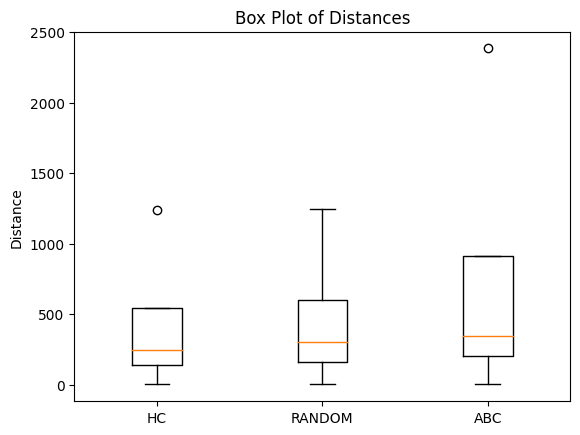

In [70]:
import matplotlib.pyplot as plt

# Assuming you have lists or arrays for each set of distances
distances_HC = [average_distance_HC, min_distance_HC, max_distance_HC, std_distance_HC]
distances_RANDOM = [average_distance_RANDOM, min_distance_RANDOM, max_distance_RANDOM, std_distance_RANDOM]
distances_ABC = [average_distance_ABC, min_distance_ABC, max_distance_ABC, std_distance_ABC]

# Combine the data into a list of lists
data = [distances_HC, distances_RANDOM, distances_ABC]

# Labels for the box plot
labels = ['HC', 'RANDOM', 'ABC']

# Create a box plot
plt.boxplot(data, labels=labels)
plt.title('Box Plot of Distances')
plt.ylabel('Distance')
plt.show()

## E) Picking Strategie: mid-Point/ Picking Method








### **1) AI-driven storage location assignment clustering**




In [ ]:
import pandas as pd
from google.colab import files
# Load the 'hierarchical_cluster_assignments.csv' file
cluster_assignments = df_HC

# Sort the cluster assignments by 'Cluster' column
cluster_assignments = cluster_assignments.sort_values(by='Cluster')

# Calculate the number of items in each cluster
cluster_sizes = cluster_assignments['Cluster'].value_counts()

# Initialize Emplacement counter
emplacement_counter = 1

# Create a new DataFrame to store the results
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Iterate through each cluster
for cluster, size in cluster_sizes.items():
    # Assign Emplacement values from emplacement_counter to emplacement_counter + size - 1
    result_df = pd.concat([result_df, cluster_assignments[cluster_assignments['Cluster'] == cluster]], ignore_index=True)
    result_df.loc[result_df['Cluster'] == cluster, 'Emplacement'] = list(range(emplacement_counter, emplacement_counter + size))

    # Update the Emplacement counter
    emplacement_counter += size
result_df['Items'] = result_df['Items'].str.replace('.csv', '')
# Save the result to a new CSV file
result_df.to_csv('cluster_emplacement_assignments_HC.csv', index=False)

# Download the Excel file to your local machine
files.download('cluster_emplacement_assignments_HC.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd



merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

merged_df.reset_index(drop=True, inplace=True)



In [ ]:
import pandas as pd
import os

# Function to determine if an emplacement is in the front or rear aisle
def determine_aisle(emplacement):
    i = emplacement - (emplacement // 40) * 40
    return 1 if (0 <= i <= 10) or (31 <= i <= 40) else 0

# Create a directory to store CSV files
output_directory = 'grouped_invoice_csv_files_HC2'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over unique 'InvoiceNo'
for invoice_no in merged_df['InvoiceNo'].unique():
    # Filter data for the current 'InvoiceNo'
    invoice_data = merged_df[merged_df['InvoiceNo'] == invoice_no]

    # Check if the DataFrame is not empty
    if not invoice_data.empty:
        # Select relevant columns and create a copy using .loc
        invoice_csv_data = invoice_data.loc[:, ['Items', 'Cluster', 'Emplacement']].copy()

        # Create a new column 'front/rear aisle' and fill it based on the conditions
        invoice_csv_data['front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)

        # Save the DataFrame to a CSV file
        csv_file_path = f"{output_directory}/Invoice_{invoice_no}.csv"
        invoice_csv_data.to_csv(csv_file_path, index=False)
    else:
        pass  # Do nothing if no data found for InvoiceNo


In [ ]:
import pandas as pd
import os

# Function to calculate distance between two positions A and B in the warehouse
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        if (i >= 0 and i <= 10) or (i >= 31 and i <= 40):
            distance = distance_matrix.loc[i, j-1]
        else:
            distance = distance_matrix.loc[i, 21] + distance_matrix.loc[20, j] + 10 * ((B // 40) - (A // 40))
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'grouped_invoice_csv_files_HC2'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_HC = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances) / 6  # Adjusted for your specific use case

                # Add the total distance to the list
                distances_list_HC.append(total_distance)

                # Print or use the total distance as needed
                print(f"Total distance for {csv_file}: {total_distance}")
            else:
                print(f"No valid distances calculated for {csv_file}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average distance for all valid CSV files
if distances_list_HC:
    average_distance_HC = sum(distances_list_HC) / len(distances_list_HC)
    print(f"Average distance for all valid CSV files: {average_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_HC = min(distances_list_HC)
    max_distance_HC = max(distances_list_HC)
    std_distance_HC = pd.Series(distances_list_HC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_HC}")
    print(f"Maximum distance: {max_distance_HC}")
    print(f"Standard deviation of distances: {std_distance_HC}")
else:
    print("No valid CSV files found.")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Total distance for Invoice_576775.csv: 21.333333333333332
Error processing Invoice_538156.csv: 0. Skipping to the next CSV.
Total distance for Invoice_574319.csv: 47.0
Total distance for Invoice_568699.csv: 40.0
No valid distances calculated for Invoice_557756.csv
Total distance for Invoice_576224.csv: 8.666666666666666
Total distance for Invoice_555916.csv: 46.333333333333336
Total distance for Invoice_563206.csv: 57.0
No valid distances calculated for Invoice_557133.csv
Total distance for Invoice_556929.csv: 19.666666666666668
Total distance for Invoice_549996.csv: 38.0
Total distance for Invoice_544194.csv: 75.33333333333333
Total distance for Invoice_547102.csv: 207.66666666666666
Error processing Invoice_579408.csv: 0. Skipping to the next CSV.
Total distance for Invoice_540794.csv: 43.0
Total distance for Invoice_537963.csv: 56.666666666666664
No valid distances calculated for Invoice_561509.csv
Total d

In [ ]:
# Calculate the average distance for all valid CSV files
if distances_list_HC:
    average_distance_HC = sum(distances_list_HC) / len(distances_list_HC)
    print(f"Average distance for all valid CSV files: {average_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_HC = min(distances_list_HC)
    max_distance_HC = max(distances_list_HC)
    std_distance_HC = pd.Series(distances_list_HC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_HC}")
    print(f"Maximum distance: {max_distance_HC}")
    print(f"Standard deviation of distances: {std_distance_HC}")
else:
    print("No valid CSV files found.")

Average distance for all valid CSV files: 66.33998915347843
Minimum distance (excluding 0s): 0.3333333333333333
Maximum distance: 367.6666666666667
Standard deviation of distances: 43.63568581472254


### **2) Random Storage**

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [ ]:
import random
# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Assign values to result_df
for csv_file in mydataset:
    # Extract item name from the CSV file path
    item_name = csv_file.replace('.csv', '')

    # Assign values to the DataFrame
    result_df = result_df.append({
        'Items': item_name,
        'Cluster': 1,
        'Emplacement': random.randint(1, 788)}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('result_df.csv', index=False)



In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)


In [ ]:
import pandas as pd
import os

# Function to determine if an emplacement is in the front or rear aisle
def determine_aisle(emplacement):
    i = emplacement - (emplacement // 40) * 40
    return 1 if (0 <= i <= 10) or (31 <= i <= 40) else 0

# Create a directory to store grouped CSV files
output_directory = 'invoice_csv_files_RANDOM2'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over chunks of 6 unique 'InvoiceNo'
for i in range(0, len(merged_df['InvoiceNo'].unique()), 6):
    # Get 6 unique 'InvoiceNo' for the current chunk
    chunk_invoices = merged_df['InvoiceNo'].unique()[i:i+6]

    # Initialize an empty DataFrame to store grouped data
    grouped_data = pd.DataFrame()

    # Iterate over each 'InvoiceNo' in the chunk
    for invoice_no in chunk_invoices:
        # Filter data for the current 'InvoiceNo' and create a copy using .loc
        invoice_data = merged_df.loc[merged_df['InvoiceNo'] == invoice_no, :].copy()

        # Check if the DataFrame is not empty
        if not invoice_data.empty:
            # Select relevant columns and create a copy
            invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']].copy()

            # Create a new column 'front/rear aisle' and fill it based on the conditions
            invoice_csv_data.loc[:, 'front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)

            # Append the data to the grouped DataFrame
            grouped_data = pd.concat([grouped_data, invoice_csv_data], ignore_index=True)
        else:
            pass  # Do nothing if no data found for InvoiceNo

    # Save


In [ ]:
import pandas as pd
import os

# Function to calculate distance between two positions A and B
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        if (i >= 0 and i <= 10) or (i >= 31 and i <= 40):
            distance = distance_matrix.loc[i, j-1]
        else:
            distance = distance_matrix.loc[i, 21] + distance_matrix.loc[20, j] + 10 * ((B // 40) - (A // 40))
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_RANDOM2'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_RANDOM = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances) / 6

                # Add the total distance to the list
                distances_list_RANDOM.append(total_distance)

                # Print or use the total distance as needed
                print(f"Total distance for {csv_file}: {total_distance}")
            else:
                print(f"No valid distances calculated for {csv_file}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average distance for all valid CSV files
if distances_list_RANDOM:
    average_distance_RANDOM = sum(distances_list_RANDOM) / len(distances_list_RANDOM)
    print(f"Average distance for all valid CSV files: {average_distance_RANDOM}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_RANDOM = min(distances_list_RANDOM)
    max_distance_RANDOM = max(distances_list_RANDOM)
    std_distance_RANDOM = pd.Series(distances_list_RANDOM).std()

    print(f"Minimum distance (excluding 0s): {min_distance_RANDOM}")
    print(f"Maximum distance: {max_distance_RANDOM}")
    print(f"Standard deviation of distances: {std_distance_RANDOM}")
else:
    print("No valid CSV files found.")


Error processing Grouped_Invoices_2.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_13.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_16.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_7.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_15.csv: 0. Skipping to the next CSV.
Total distance for Grouped_Invoices_8.csv: 187.33333333333334
Error processing Grouped_Invoices_6.csv: 0. Skipping to the next CSV.
Total distance for Grouped_Invoices_11.csv: 235.0
Error processing Grouped_Invoices_9.csv: 0. Skipping to the next CSV.
Total distance for Grouped_Invoices_1.csv: 143.0
Total distance for Grouped_Invoices_3.csv: 150.66666666666666
Total distance for Grouped_Invoices_10.csv: 238.33333333333334
Error processing Grouped_Invoices_14.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_12.csv: 0. Skipping to the next CSV.
Total distance for Grouped_Invoices_4.csv: 207.0
Error processing Grouped_Invoi

In [ ]:
# Calculate the average distance for all valid CSV files
if distances_list_RANDOM:
    average_distance_RANDOM = sum(distances_list_RANDOM) / len(distances_list_RANDOM)
    print(f"Average distance for all valid CSV files: {average_distance_RANDOM}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_RANDOM = min(distances_list_RANDOM)
    max_distance_RANDOM = max(distances_list_RANDOM)
    std_distance_RANDOM = pd.Series(distances_list_RANDOM).std()

    print(f"Minimum distance (excluding 0s): {min_distance_RANDOM}")
    print(f"Maximum distance: {max_distance_RANDOM}")
    print(f"Standard deviation of distances: {std_distance_RANDOM}")
else:
    print("No valid CSV files found.")

Average distance for all valid CSV files: 193.55555555555557
Minimum distance (excluding 0s): 143.0
Maximum distance: 238.33333333333334
Standard deviation of distances: 40.834988628580476


### **3) old school ABC Classification**

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
import pandas as pd
import random

# Function to get the frequency of items in invoiceno
def get_invoice_frequency(csv_file):
    # Replace this with your actual code to calculate frequency
    # Example: Read the CSV file and count unique invoicenos
    df = data
    return len(df['InvoiceNo'].unique())

# Calculate the frequency of each item in mydataset
item_frequencies = {}

for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')
    frequency = get_invoice_frequency(csv_file)
    item_frequencies[item_name] = frequency

# Sort items by frequency in descending order
sorted_items = sorted(item_frequencies.items(), key=lambda x: x[1], reverse=True)

# Extract top 190 items and most frequent 380 items
top_190_items = [item[0] for item in sorted_items[:190]]
most_frequent_380_items = [item[0] for item in sorted_items[190:570]]

# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster'])

# Assign ABC class based on your criteria
for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')

    if item_name in top_190_items:
        abc_class = 'A'
    elif item_name in most_frequent_380_items:
        abc_class = 'B'
    else:
        abc_class = 'C'

    result_df = result_df.append({'Items': item_name, 'Cluster': abc_class}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('ABC_classification.csv', index=False)




In [ ]:
# Update the result_df DataFrame with the 'Emplacement' column successively
result_df['Emplacement'] = list(range(1, len(result_df) + 1))

# Save the updated result_df to a new CSV file
result_df.to_csv('ABC_classification_with_Successive_Emplacement.csv', index=False)




In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

# Convert 'Emplacement' column to integers and format it
merged_df['Emplacement'] = merged_df['Emplacement'].fillna(0).astype(int).astype(str)


'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)


In [ ]:
import pandas as pd
import os

# Function to determine if an emplacement is in the front or rear aisle
def determine_aisle(emplacement):
    i = emplacement - (emplacement // 40) * 40
    return 1 if (0 <= i <= 10) or (31 <= i <= 40) else 0

# Create a directory to store grouped CSV files
output_directory = 'invoice_csv_files_ABC_class'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over chunks of 6 unique 'InvoiceNo'
for i in range(0, len(merged_df['InvoiceNo'].unique()), 6):
    # Get 6 unique 'InvoiceNo' for the current chunk
    chunk_invoices = merged_df['InvoiceNo'].unique()[i:i+6]

    # Initialize an empty DataFrame to store grouped data
    grouped_data = pd.DataFrame()

    # Iterate over each 'InvoiceNo' in the chunk
    for invoice_no in chunk_invoices:
        # Filter data for the current 'InvoiceNo' and create a copy using .loc
        invoice_data = merged_df.loc[merged_df['InvoiceNo'] == invoice_no, :].copy()

        # Check if the DataFrame is not empty
        if not invoice_data.empty:
            # Select relevant columns and create a copy
            invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']].copy()

            # Create a new column 'front/rear aisle' and fill it based on the conditions
            invoice_csv_data.loc[:, 'front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)

            # Append the data to the grouped DataFrame
            grouped_data = pd.concat([grouped_data, invoice_csv_data], ignore_index=True)
        else:
            pass  # Do nothing if no data found for InvoiceNo

    # Save the grouped DataFrame to a CSV file
    grouped_csv_file_path = f"{output_directory}/Grouped_Invoices_{i//6 + 1}.csv"
    grouped_data.to_csv(grouped_csv_file_path, index=False)


In [ ]:
import pandas as pd
import os

# Function to calculate distance between two positions A and B
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        if (i >= 0 and i <= 10) or (i >= 31 and i <= 40):
            distance = distance_matrix.loc[i, j-1]
        else:
            distance = distance_matrix.loc[i, 21] + distance_matrix.loc[20, j] + 10 * ((B // 40) - (A // 40))
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_ABC_class'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store distances for each valid CSV file
distances_list_ABC = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Calculate distances between consecutive 'Emplacement' values
            distances = [calculate_distance(df['Emplacement'].iloc[i], df['Emplacement'].iloc[i + 1], distance_matrix)
                         for i in range(len(df) - 1)]

            # Check if distances list is not empty and does not contain only 0s before accessing its elements
            if distances and not all(distance == 0 for distance in distances):
                # Sum the distances to get the total distance
                total_distance = sum(distances) / 6

                # Add the total distance to the list
                distances_list_ABC.append(total_distance)

                # Print or use the total distance as needed
                print(f"Total distance for {csv_file}: {total_distance}")
            else:
                print(f"No valid distances calculated for {csv_file}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average distance for all valid CSV files
if distances_list_ABC:
    average_distance_ABC = sum(distances_list_ABC) / len(distances_list_ABC)
    print(f"Average distance for all valid CSV files: {average_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_ABC = min(distances_list_ABC)
    max_distance_ABC = max(distances_list_ABC)
    std_distance_ABC = pd.Series(distances_list_ABC).std()

    print(f"Minimum distance (excluding 0s): {min_distance_ABC}")
    print(f"Maximum distance: {max_distance_ABC}")
    print(f"Standard deviation of distances: {std_distance_ABC}")
else:
    print("No valid CSV files found.")


Error processing Grouped_Invoices_1494.csv: 0. Skipping to the next CSV.
Total distance for Grouped_Invoices_3074.csv: 258.3333333333333
Error processing Grouped_Invoices_2215.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_2637.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_1940.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_1894.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_862.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_751.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_2750.csv: 0. Skipping to the next CSV.
Total distance for Grouped_Invoices_2289.csv: 129.0
Error processing Grouped_Invoices_3188.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_2043.csv: 0. Skipping to the next CSV.
Total distance for Grouped_Invoices_2241.csv: 273.6666666666667
Total distance for Grouped_Invoices_1919.csv: 134.66666666666666
Error processing Grouped_In

In [ ]:
if distances_list_ABC:
    average_distance_ABC = sum(distances_list_ABC) / len(distances_list_ABC)
    print(f"Average distance ABC: {average_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of distances
    min_distance_ABC = min(distances_list_ABC)
    max_distance_ABC = max(distances_list_ABC)
    std_distance_ABC = pd.Series(distances_list_ABC).std()

    print(f"Minimum distance ABC: {min_distance_ABC}")
    print(f"Maximum distance ABC: {max_distance_ABC}")
    print(f"Standard deviation ABC: {std_distance_ABC}")
else:
    print("No valid CSV files found.")


Average distance ABC: 212.66562336984893
Minimum distance ABC: 55.333333333333336
Maximum distance ABC: 414.6666666666667
Standard deviation ABC: 57.53845955890496


In [ ]:
print(f"Average distance HC:",average_distance_HC)
print(f"Minimum distance HC: {min_distance_HC}")
print(f"Maximum distance HC: {max_distance_HC}")
print(f"Standard deviation of distances HC: {std_distance_HC}")
print(f"Average distance RADNOM:",average_distance_RANDOM)
print(f"Minimum distance RANDOM: {min_distance_RANDOM}")
print(f"Maximum distance RANDOM: {max_distance_RANDOM}")
print(f"Standard deviation RANDOM: {std_distance_RANDOM}")
print(f"Average distance ABC:",average_distance_ABC)
print(f"Minimum distance ABC: {min_distance_ABC}")
print(f"Maximum distance ABC: {max_distance_ABC}")
print(f"Standard deviation ABC: {std_distance_ABC}")

Average distance HC: 66.33998915347843
Minimum distance HC: 0.3333333333333333
Maximum distance HC: 367.6666666666667
Standard deviation of distances HC: 43.63568581472254
Average distance RADNOM: 193.55555555555557
Minimum distance RANDOM: 143.0
Maximum distance RANDOM: 238.33333333333334
Standard deviation RANDOM: 40.834988628580476
Average distance ABC: 212.66562336984893
Minimum distance ABC: 55.333333333333336
Maximum distance ABC: 414.6666666666667
Standard deviation ABC: 57.53845955890496


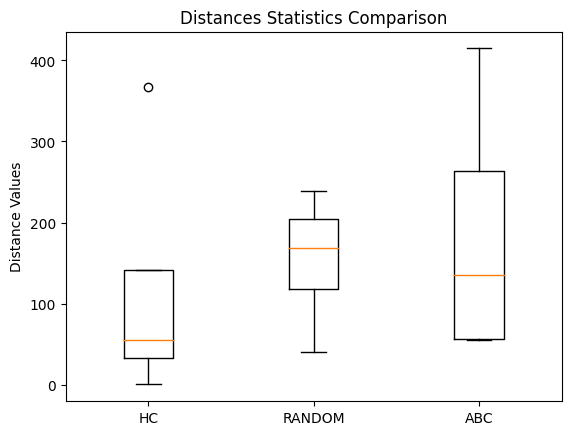

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have lists or arrays for each set of distances
distances_HC = [average_distance_HC, min_distance_HC, max_distance_HC, std_distance_HC]
distances_RANDOM = [average_distance_RANDOM, min_distance_RANDOM, max_distance_RANDOM, std_distance_RANDOM]
distances_ABC = [average_distance_ABC, min_distance_ABC, max_distance_ABC, std_distance_ABC]

# Data for boxplot
data = [distances_HC, distances_RANDOM, distances_ABC]
labels = ['HC', 'RANDOM', 'ABC']

# Create boxplots
plt.boxplot(data, labels=labels)
plt.title('Distances Statistics Comparison')
plt.ylabel('Distance Values')
plt.show()


Summary and Anova test

In [ ]:
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Ensure all lists have the same length
min_length = min(len(distances_list_ABC), len(distances_list_HC), len(distances_list_RANDOM))

# Trim the lists to the minimum length
distances_list_ABC = distances_list_ABC[:min_length]
distances_list_HC = distances_list_HC[:min_length]
distances_list_RANDOM = distances_list_RANDOM[:min_length]


# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': distances_list_ABC,
    'HC': distances_list_HC,
    'RANDOM': distances_list_RANDOM,
})

# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': distances_list_ABC,
    'HC': distances_list_HC,
    'RANDOM': distances_list_RANDOM,
})

# Perform One-Way ANOVA
anova_result = f_oneway(
    data['ABC'],
    data['HC'],
    data['RANDOM'],
)

# Display the ANOVA result
print("One-way ANOVA p-value:", anova_result.pvalue)

# Perform Tukey's test for multiple comparisons (post hoc analysis)
flattened_data = np.concatenate([data['ABC'], data['HC'], data['RANDOM']])
labels = np.concatenate([['ABC'] * len(data['ABC']), ['HC'] * len(data['HC']), ['RANDOM'] * len(data['RANDOM']) ])

tukey_result = pairwise_tukeyhsd(flattened_data, labels)

# Display the Tukey's test results
print(tukey_result)

# Additional Statistics
mean_distances = data.mean()
std_distances = data.std()

# Display the mean and standard deviation for each group
print("\nMean distances:")
print(mean_distances)
print("\nStandard deviation distances:")
print(std_distances)


One-way ANOVA p-value: 0.0006198736631506024
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
   ABC     HC   -146.5 0.0009 -228.9052 -64.0948   True
   ABC RANDOM -19.4444 0.8154 -101.8496  62.9607  False
    HC RANDOM 127.0556 0.0031   44.6504 209.4607   True
-------------------------------------------------------

Mean distances:
ABC       213.000000
HC         66.500000
RANDOM    193.555556
dtype: float64

Standard deviation distances:
ABC       71.110868
HC        48.312754
RANDOM    40.834989
dtype: float64


## F) Picking Strategie: mid-Point/ Picking Method: Zone order picking





### **1) AI-driven storage location assignment clustering**

In [ ]:
import pandas as pd
from google.colab import files
# Load the 'hierarchical_cluster_assignments.csv' file
cluster_assignments = df_HC

# Sort the cluster assignments by 'Cluster' column
cluster_assignments = cluster_assignments.sort_values(by='Cluster')

# Calculate the number of items in each cluster
cluster_sizes = cluster_assignments['Cluster'].value_counts()

# Initialize Emplacement counter
emplacement_counter = 1

# Create a new DataFrame to store the results
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Iterate through each cluster
for cluster, size in cluster_sizes.items():
    # Assign Emplacement values from emplacement_counter to emplacement_counter + size - 1
    result_df = pd.concat([result_df, cluster_assignments[cluster_assignments['Cluster'] == cluster]], ignore_index=True)
    result_df.loc[result_df['Cluster'] == cluster, 'Emplacement'] = list(range(emplacement_counter, emplacement_counter + size))

    # Update the Emplacement counter
    emplacement_counter += size
result_df['Items'] = result_df['Items'].str.replace('.csv', '')
# Save the result to a new CSV file
result_df.to_csv('cluster_emplacement_assignments_HC.csv', index=False)

# Download the Excel file to your local machine
files.download('cluster_emplacement_assignments_HC.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd



merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

merged_df.reset_index(drop=True, inplace=True)



<ipython-input-78-fd4c58f67d14>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')


In [ ]:
import pandas as pd
import os

# Function to determine if an emplacement is in the front or rear aisle
def determine_aisle(emplacement):
    i = emplacement - (emplacement // 40) * 40
    return 1 if (0 <= i <= 10) or (31 <= i <= 40) else 0

# Create a directory to store grouped CSV files
output_directory = 'grouped_invoice_csv_files_HC'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over chunks of 6 unique 'InvoiceNo'
for i in range(0, len(merged_df['InvoiceNo'].unique()), 6):
    # Get 6 unique 'InvoiceNo' for the current chunk
    chunk_invoices = merged_df['InvoiceNo'].unique()[i:i+6]

    # Initialize an empty DataFrame to store grouped data
    grouped_data = pd.DataFrame()

    # Iterate over each 'InvoiceNo' in the chunk
    for invoice_no in chunk_invoices:
        # Filter data for the current 'InvoiceNo' and create a copy using .loc
        invoice_data = merged_df.loc[merged_df['InvoiceNo'] == invoice_no, :].copy()

        # Check if the DataFrame is not empty
        if not invoice_data.empty:
            # Select relevant columns and create a copy
            invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']].copy()

            # Create a new column 'front/rear aisle' and fill it based on the conditions
            invoice_csv_data.loc[:, 'front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)

            # Append the data to the grouped DataFrame
            grouped_data = pd.concat([grouped_data, invoice_csv_data], ignore_index=True)
        else:
            pass  # Do nothing if no data found for InvoiceNo

    # Save the grouped DataFrame to a CSV file
    grouped_csv_file_path = f"{output_directory}/Grouped_Invoices_{i//6 + 1}.csv"
    grouped_data.to_csv(grouped_csv_file_path, index=False)


In [ ]:
import os
import pandas as pd

# Define or import the calculate_distance function and distance_matrix variable

# Function to calculate distance between two positions A and Bin warehouse
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        if (i >= 0 and i <= 10) or (i >= 31 and i <= 40):
            distance = distance_matrix.loc[i, j-1]
        else:
            distance = distance_matrix.loc[i, 21] + distance_matrix.loc[20, j] + 10 * ((B // 40) - (A // 40))
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files_HC' directory
csv_directory = 'grouped_invoice_csv_files_HC'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store total distances for each valid CSV file
total_distances_list_HC = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Initialize total distance for the current CSV file
            total_distance = 0

            # Iterate over unique clusters in the DataFrame
            for cluster in df['Cluster'].unique():
                # Filter data for the current cluster
                cluster_data = df[df['Cluster'] == cluster]

                # Calculate distances between consecutive 'Emplacement' values for the current cluster
                distances = [calculate_distance(cluster_data['Emplacement'].iloc[i],
                                                cluster_data['Emplacement'].iloc[i + 1],
                                                distance_matrix)
                             for i in range(len(cluster_data) - 1)]

                # Sum the distances for the current cluster
                cluster_total_distance = sum(distances)

                # Add the cluster distance to the total distance for the CSV file
                total_distance += cluster_total_distance

                # Print or use the cluster distance as needed
                print(f"Distance for Cluster {cluster} in {csv_file}: {cluster_total_distance}")

            # Add the total distance for the CSV file to the list
            total_distances_list_HC.append(total_distance)

            # Print or use the total distance for the CSV file as needed
            print(f"Total distance for {csv_file}: {total_distance}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average total distance for all valid CSV files
if total_distances_list_HC:
    average_total_distance_HC = sum(total_distances_list_HC) / len(total_distances_list_HC)
    print(f"Average total distance for all valid CSV files: {average_total_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_HC = min(total_distances_list_HC)
    max_total_distance_HC = max(total_distances_list_HC)
    std_total_distance_HC = pd.Series(total_distances_list_HC).std()

    print(f"Minimum total distance: {min_total_distance_HC}")
    print(f"Maximum total distance: {max_total_distance_HC}")
    print(f"Standard deviation of total distances: {std_total_distance_HC}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
Distance for Cluster 10 in Grouped_Invoices_502.csv: 0
Error processing Grouped_Invoices_502.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_2452.csv: 0. Skipping to the next CSV.
Distance for Cluster 6 in Grouped_Invoices_570.csv: 292
Distance for Cluster 0 in Grouped_Invoices_570.csv: 124
Distance for Cluster 9 in Grouped_Invoices_570.csv: 38
Distance for Cluster 12 in Grouped_Invoices_570.csv: 22
Distance for Cluster 11 in Grouped_Invoices_570.csv: 100
Distance for Cluster 2 in Grouped_Invoices_570.csv: 48
Distance for Cluster 7 in Grouped_Invoices_570.csv: 44
Distance for Cluster 4 in Grouped_Invoices_570.csv: 38
Distance for Cluster 3 in Grouped_Invoices_570.csv: 6
Distance for Cluster 1 in Grouped_Invoices_570.csv: 20
Total distance for Grouped_Invoices_570.csv: 732
Distance for Cluster 6 in Grouped_Invoices_3649.csv: 154
Distance for Cluster 9 in Grouped_Invoices_3649.csv: 82
Distance for Cluster 11 in Groupe

In [ ]:
# Calculate the average distance for all clusters in valid CSV files
if total_distances_list_HC:
    average_total_distance_HC = sum(total_distances_list_HC) / len(total_distances_list_HC)
    print(f"Average total distance for all clusters in valid CSV files: {average_total_distance_HC}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_HC = min(total_distances_list_HC)
    max_total_distance_HC = max(total_distances_list_HC)
    std_total_distance_HC = pd.Series(total_distances_list_HC).std()

    print(f"Minimum total distance: {min_total_distance_HC}")
    print(f"Maximum total distance: {max_total_distance_HC}")
    print(f"Standard deviation of total distances: {std_total_distance_HC}")
else:
    print("No valid CSV files found.")


Average total distance for all clusters in valid CSV files: 701.2093896713615
Minimum total distance: 0
Maximum total distance: 2472
Standard deviation of total distances: 502.07898824594025


### **2) Random Storage**

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [ ]:
import random
# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster', 'Emplacement'])

# Assign values to result_df
for csv_file in mydataset:
    # Extract item name from the CSV file path
    item_name = csv_file.replace('.csv', '')

    # Assign values to the DataFrame
    result_df = result_df.append({
        'Items': item_name,
        'Cluster': 1,
        'Emplacement': random.randint(1, 788)}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('result_df.csv', index=False)



In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)



<ipython-input-87-b9e9f1e277a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')


In [ ]:
import pandas as pd
import os

# Function to determine if an emplacement is in the front or rear aisle
def determine_aisle(emplacement):
    i = emplacement - (emplacement // 40) * 40
    return 1 if (0 <= i <= 10) or (31 <= i <= 40) else 0

# Create a directory to store grouped CSV files
output_directory = 'invoice_csv_files_RANDOM'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over chunks of 6 unique 'InvoiceNo'
for i in range(0, len(merged_df['InvoiceNo'].unique()), 6):
    # Get 6 unique 'InvoiceNo' for the current chunk
    chunk_invoices = merged_df['InvoiceNo'].unique()[i:i+6]

    # Initialize an empty DataFrame to store grouped data
    grouped_data = pd.DataFrame()

    # Iterate over each 'InvoiceNo' in the chunk
    for invoice_no in chunk_invoices:
        # Filter data for the current 'InvoiceNo' and create a copy using .loc
        invoice_data = merged_df.loc[merged_df['InvoiceNo'] == invoice_no, :].copy()

        # Check if the DataFrame is not empty
        if not invoice_data.empty:
            # Select relevant columns and create a copy
            invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']].copy()

            # Create a new column 'front/rear aisle' and fill it based on the conditions
            invoice_csv_data.loc[:, 'front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)

            # Append the data to the grouped DataFrame
            grouped_data = pd.concat([grouped_data, invoice_csv_data], ignore_index=True)
        else:
            pass  # Do nothing if no data found for InvoiceNo

    # Save the grouped DataFrame to a CSV file
    grouped_csv_file_path = f"{output_directory}/Grouped_Invoices_{i//6 + 1}.csv"
    grouped_data.to_csv(grouped_csv_file_path, index=False)


In [ ]:
import os
import pandas as pd

# Define or import the calculate_distance function and distance_matrix variable

# Function to calculate distance between two positions A and B in the warehouse
def calculate_distance(A, B, distance_matrix, front_rear_aisle):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        distance = distance_matrix.loc[i, j-1]
    else:
        if (i >= 0 and i <= 10) or (i >= 31 and i <= 40):
            distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))
        else:
            # Handle the case where i is not in the specified ranges
            distance = 0  # You may want to adjust this based on your specific requirements

    return distance

# Assuming the CSV files are in the 'invoice_csv_files' directory
csv_directory = 'invoice_csv_files_RANDOM'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store total distances for each valid CSV file
total_distances_list_RANDOM = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Initialize total distance for the current CSV file
            total_distance = 0

            # Iterate over unique clusters in the DataFrame
            for cluster in df['Cluster'].unique():
                # Filter data for the current cluster
                cluster_data = df[df['Cluster'] == cluster]

                # Calculate distances between consecutive 'Emplacement' values for the current cluster
                distances = [calculate_distance(cluster_data['Emplacement'].iloc[i],
                                                cluster_data['Emplacement'].iloc[i + 1],
                                                distance_matrix, 1)  # Assuming 'front/rear aisle' condition is 1
                             for i in range(len(cluster_data) - 1)]

                # Sum the distances for the current cluster
                cluster_total_distance = sum(distances)

                # Add the cluster distance to the total distance for the CSV file
                total_distance += cluster_total_distance

                # Print or use the cluster distance as needed
                print(f"Distance for Cluster {cluster} in {csv_file}: {cluster_total_distance}")

            # Add the total distance for the CSV file to the list
            total_distances_list_RANDOM.append(total_distance)

            # Print or use the total distance for the CSV file as needed
            print(f"Total distance for {csv_file}: {total_distance}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average total distance for all valid CSV files
if total_distances_list_RANDOM:
    average_total_distance_RANDOM = sum(total_distances_list_RANDOM) / len(total_distances_list_RANDOM)
    print(f"Average total distance for all valid CSV files: {average_total_distance_RANDOM}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_RANDOM = min(distances_list_RANDOM)
    max_total_distance_RANDOM = max(distances_list_RANDOM)
    std_total_distance_RANDOM = pd.Series(distances_list_RANDOM).std()

    print(f"Minimum total distance: {min_total_distance_RANDOM}")
    print(f"Maximum total distance: {max_total_distance_RANDOM}")
    print(f"Standard deviation of total distances: {std_total_distance_RANDOM}")
else:
    print("No valid CSV files found.")


Error processing Grouped_Invoices_1494.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_3074.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_2215.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_2637.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_1940.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_1894.csv: 0. Skipping to the next CSV.
Distance for Cluster 1 in Grouped_Invoices_862.csv: 724
Total distance for Grouped_Invoices_862.csv: 724
Error processing Grouped_Invoices_751.csv: 0. Skipping to the next CSV.
Distance for Cluster 1 in Grouped_Invoices_2750.csv: 470
Total distance for Grouped_Invoices_2750.csv: 470
Distance for Cluster 1 in Grouped_Invoices_2289.csv: 424
Total distance for Grouped_Invoices_2289.csv: 424
Error processing Grouped_Invoices_3188.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_2043.csv: 0. Skipping to the next CSV.
Error processing Grouped_

In [ ]:
# Calculate the average total distance for all valid CSV files
if distances_list_RANDOM:
    average_total_distance_RANDOM = sum(total_distances_list_RANDOM) / len(total_distances_list_RANDOM)
    print(f"Average total distance for all valid CSV files: {average_total_distance_RANDOM}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_RANDOM = min(distances_list_RANDOM)
    max_total_distance_RANDOM = max(distances_list_RANDOM)
    std_total_distance_RANDOM = pd.Series(distances_list_RANDOM).std()

    print(f"Minimum total distance: {min_total_distance_RANDOM}")
    print(f"Maximum total distance: {max_total_distance_RANDOM}")
    print(f"Standard deviation of total distances: {std_total_distance_RANDOM}")
else:
    print("No valid CSV files found.")


Average total distance for all valid CSV files: 589.2545090180361
Minimum total distance: 143.0
Maximum total distance: 238.33333333333334
Standard deviation of total distances: 40.834988628580476


### **3) old school ABC Classification**

In [ ]:
# encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv(Mydata, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue
        data = pd.read_csv(Mydata, encoding='your_encoding_here')

data = data[data['Quantity'] >= 0]

num_stockcodes_before = len(data['StockCode'].unique())

stockcode_quantities = data.groupby('StockCode')['Quantity'].sum()
total_quantity = stockcode_quantities.sum()
stockcode_contributions = stockcode_quantities / total_quantity
sorted_stockcodes = stockcode_contributions.sort_values(ascending=False)
cumulative_contributions = sorted_stockcodes.cumsum()
top_20_threshold = int(len(sorted_stockcodes) * 0.2)
top_stockcodes = sorted_stockcodes.index[:top_20_threshold]

num_stockcodes_after = len(top_stockcodes)


# 4)  Group data by InvoiceDate and StockCode, summing the Quantity
grouped_data = data[data['StockCode'].isin(top_stockcodes)].groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()

# Generate new dataframes
mydataset = []
for stockcode in top_stockcodes:
    stock_data = grouped_data[grouped_data['StockCode'] == stockcode][['InvoiceDate', 'Quantity']]
    csv_file_path = f'{stockcode}.csv'
    stock_data.to_csv(csv_file_path, index=False)
    mydataset.append(csv_file_path)

# Identify the minimum number of lines in mydataset files
min_lines = float('inf')
for file_path in mydataset:
    file_data = pd.read_csv(file_path)
    num_lines = len(file_data)
    min_lines = min(min_lines, num_lines)

# Print the number of StockCodes before and after, and the length of mydataset
print("Number of Items before:", num_stockcodes_before)
print("Number of Items after 20/80 (length of mydataset):", len( mydataset))


Number of Items before: 3941
Number of Items after 20/80 (length of mydataset): 788


In [ ]:
# Change the name of the 'StockCode' column to 'Items'
data = data.rename(columns={'StockCode': 'Items'})

# Check if the 'Items' column exists in the DataFrame
print("'Items' column in the data_df DataFrame:")
print('Items' in data.columns)

'Items' column in the data_df DataFrame:
True


In [ ]:
import pandas as pd
import random

# Function to get the frequency of items in invoiceno
def get_invoice_frequency(csv_file):
    # Replace this with your actual code to calculate frequency
    # Example: Read the CSV file and count unique invoicenos
    df = data
    return len(df['InvoiceNo'].unique())

# Calculate the frequency of each item in mydataset
item_frequencies = {}

for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')
    frequency = get_invoice_frequency(csv_file)
    item_frequencies[item_name] = frequency

# Sort items by frequency in descending order
sorted_items = sorted(item_frequencies.items(), key=lambda x: x[1], reverse=True)

# Extract top 190 items and most frequent 380 items
top_190_items = [item[0] for item in sorted_items[:190]]
most_frequent_380_items = [item[0] for item in sorted_items[190:570]]

# Create result_df
result_df = pd.DataFrame(columns=['Items', 'Cluster'])

# Assign ABC class based on your criteria
for csv_file in mydataset:
    item_name = csv_file.replace('.csv', '')

    if item_name in top_190_items:
        abc_class = 'A'
    elif item_name in most_frequent_380_items:
        abc_class = 'B'
    else:
        abc_class = 'C'

    result_df = result_df.append({'Items': item_name, 'Cluster': abc_class}, ignore_index=True)

# Save the result to a new CSV file if needed
result_df.to_csv('ABC_classification.csv', index=False)



In [ ]:
# Update the result_df DataFrame with the 'Emplacement' column successively
result_df['Emplacement'] = list(range(1, len(result_df) + 1))

# Save the updated result_df to a new CSV file
result_df.to_csv('ABC_classification_with_Successive_Emplacement.csv', index=False)



In [ ]:
# Merge the 'data_df' with 'result_df' based on the 'Items' column
merged_df = data.merge(result_df[['Items', 'Cluster', 'Emplacement']], on='Items', how='left')

# Check if the 'Cluster' and 'Emplacement' columns exist in the merged DataFrame
print("'Cluster' and 'Emplacement' columns in the merged DataFrame:")
print('Cluster' in merged_df.columns)
print('Emplacement' in merged_df.columns)

# Convert 'Emplacement' column to integers and format it
merged_df['Emplacement'] = merged_df['Emplacement'].fillna(0).astype(int).astype(str)


'Cluster' and 'Emplacement' columns in the merged DataFrame:
True
True


In [ ]:
merged_df = merged_df.dropna(subset=['Cluster'])



In [ ]:
import pandas as pd

# Assuming merged_df is your DataFrame

# Convert 'Emplacement' column to numeric for sorting
merged_df['Emplacement'] = pd.to_numeric(merged_df['Emplacement'], errors='coerce')

# Sort the DataFrame by 'InvoiceNo' and 'Emplacement'
merged_df.sort_values(by=['InvoiceNo', 'Emplacement'], inplace=True)

# Optionally, if you want to reset the index
merged_df.reset_index(drop=True, inplace=True)



In [ ]:
import pandas as pd
import os

# Function to determine if an emplacement is in the front or rear aisle
def determine_aisle(emplacement):
    i = emplacement - (emplacement // 40) * 40
    return 1 if (0 <= i <= 10) or (31 <= i <= 40) else 0

# Create a directory to store grouped CSV files
output_directory = 'invoice_csv_files_ABC_class1'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over chunks of 6 unique 'InvoiceNo'
for i in range(0, len(merged_df['InvoiceNo'].unique()), 6):
    # Get 6 unique 'InvoiceNo' for the current chunk
    chunk_invoices = merged_df['InvoiceNo'].unique()[i:i+6]

    # Initialize an empty DataFrame to store grouped data
    grouped_data = pd.DataFrame()

    # Iterate over each 'InvoiceNo' in the chunk
    for invoice_no in chunk_invoices:
        # Filter data for the current 'InvoiceNo' and create a copy using .loc
        invoice_data = merged_df.loc[merged_df['InvoiceNo'] == invoice_no, :].copy()

        # Check if the DataFrame is not empty
        if not invoice_data.empty:
            # Select relevant columns and create a copy
            invoice_csv_data = invoice_data[['Items', 'Cluster', 'Emplacement']].copy()

            # Create a new column 'front/rear aisle' and fill it based on the conditions
            invoice_csv_data.loc[:, 'front/rear aisle'] = invoice_csv_data['Emplacement'].apply(determine_aisle)

            # Append the data to the grouped DataFrame
            grouped_data = pd.concat([grouped_data, invoice_csv_data], ignore_index=True)
        else:
            pass  # Do nothing if no data found for InvoiceNo

    # Save the grouped DataFrame to a CSV file
    grouped_csv_file_path = f"{output_directory}/Grouped_Invoices_{i//6 + 1}.csv"
    grouped_data.to_csv(grouped_csv_file_path, index=False)


In [ ]:
import os
import pandas as pd

# Function to calculate distance between two positions A and B
def calculate_distance(A, B, distance_matrix):
    i, j = A - (A // 40) * 40, B - (B // 40) * 40
    X = (A // 40 + 1) / (B // 40 + 1)

    if X == 1:
        if (i >= 0 and i <= 10) or (i >= 31 and i <= 40):
            distance = distance_matrix.loc[i, j-1]
        else:
            distance = distance_matrix.loc[i, 21] + distance_matrix.loc[20, j] + 10 * ((B // 40) - (A // 40))
    else:
        distance = distance_matrix.loc[i, 39] + distance_matrix.loc[2, j] + 10 * ((B // 40) - (A // 40))

    return distance

# Assuming the CSV files are in the 'invoice_csv_files_ABC_class1' directory
csv_directory = 'invoice_csv_files_ABC_class1'

# Default value to fill NaN in the 'Emplacement' column
default_value = 0  # You can adjust this value based on your data

# List to store total distances for each valid CSV file
total_distances_list_ABC = []

# Iterate over all CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(csv_directory, csv_file)

        try:
            # Load the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)

            # Sort the DataFrame by 'Emplacement' in ascending order
            df = df.sort_values(by='Emplacement')

            # Handle missing values in 'Emplacement' column
            df['Emplacement'] = df['Emplacement'].fillna(default_value).astype(int)

            # Initialize total distance for the current CSV file
            total_distance = 0

            # Iterate over unique clusters in the DataFrame
            for cluster in df['Cluster'].unique():
                # Filter data for the current cluster
                cluster_data = df[df['Cluster'] == cluster]

                # Calculate distances between consecutive 'Emplacement' values for the current cluster
                distances = [calculate_distance(cluster_data['Emplacement'].iloc[i],
                                                cluster_data['Emplacement'].iloc[i + 1],
                                                distance_matrix)
                             for i in range(len(cluster_data) - 1)]

                # Sum the distances for the current cluster
                cluster_total_distance = sum(distances)

                # Add the cluster distance to the total distance for the CSV file
                total_distance += cluster_total_distance

                # Print or use the cluster distance as needed
                print(f"Distance for Cluster {cluster} in {csv_file}: {cluster_total_distance}")

            # Add the total distance for the CSV file to the list
            total_distances_list_ABC.append(total_distance)

            # Print or use the total distance for the CSV file as needed
            print(f"Total distance for {csv_file}: {total_distance}")

        except Exception as e:
            print(f"Error processing {csv_file}: {e}. Skipping to the next CSV.")

# Calculate the average total distance for all valid CSV files
if total_distances_list_ABC:
    average_total_distance_ABC = sum(total_distances_list_ABC) / len(total_distances_list_ABC)
    print(f"Average total distance for all valid CSV files: {average_total_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_ABC = min(total_distances_list_ABC)
    max_total_distance_ABC = max(total_distances_list_ABC)
    std_total_distance_ABC = pd.Series(total_distances_list_ABC).std()

    print(f"Minimum total distance: {min_total_distance_ABC}")
    print(f"Maximum total distance: {max_total_distance_ABC}")
    print(f"Standard deviation of total distances: {std_total_distance_ABC}")
else:
    print("No valid CSV files found.")


Streaming output truncated to the last 5000 lines.
Distance for Cluster C in Grouped_Invoices_667.csv: 256
Total distance for Grouped_Invoices_667.csv: 1150
Distance for Cluster A in Grouped_Invoices_3042.csv: 496
Error processing Grouped_Invoices_3042.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_1409.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_1320.csv: 0. Skipping to the next CSV.
Distance for Cluster A in Grouped_Invoices_1417.csv: 332
Distance for Cluster B in Grouped_Invoices_1417.csv: 610
Distance for Cluster C in Grouped_Invoices_1417.csv: 332
Total distance for Grouped_Invoices_1417.csv: 1274
Error processing Grouped_Invoices_905.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_804.csv: 0. Skipping to the next CSV.
Distance for Cluster A in Grouped_Invoices_3184.csv: 484
Error processing Grouped_Invoices_3184.csv: 0. Skipping to the next CSV.
Error processing Grouped_Invoices_2109.csv: 0. Skipping to the next CSV

In [ ]:
# Calculate the average total distance for all valid CSV files
if total_distances_list_ABC:
    average_total_distance_ABC = sum(total_distances_list_ABC) / len(total_distances_list_ABC)
    print(f"Average total distance for all valid CSV files: {average_total_distance_ABC}")

    # Calculate the minimum, maximum, and standard deviation of total distances
    min_total_distance_ABC = min(total_distances_list_ABC)
    max_total_distance_ABC = max(total_distances_list_ABC)
    std_total_distance_ABC = pd.Series(total_distances_list_ABC).std()

    print(f"Minimum total distance: {min_total_distance_ABC}")
    print(f"Maximum total distance: {max_total_distance_ABC}")
    print(f"Standard deviation of total distances: {std_total_distance_ABC}")
else:
    print("No valid CSV files found.")


Average total distance for all valid CSV files: 1179.8466076696166
Minimum total distance: 188
Maximum total distance: 2400
Standard deviation of total distances: 355.41377065477536


In [ ]:
print(f"Average distance HC:",average_total_distance_HC)
print(f"Minimum distance HC: {min_total_distance_HC}")
print(f"Maximum distance HC: {max_total_distance_HC}")
print(f"Standard deviation of distances HC: {std_total_distance_HC}")
print(f"Average distance RADNOM:",average_total_distance_RANDOM)
print(f"Minimum distance RANDOM: {min_total_distance_RANDOM}")
print(f"Maximum distance RANDOM: {max_total_distance_RANDOM}")
print(f"Standard deviation RANDOM: {std_total_distance_RANDOM}")
print(f"Average distance ABC:",average_total_distance_ABC)
print(f"Minimum distance ABC: {min_total_distance_ABC}")
print(f"Maximum distance ABC: {max_total_distance_ABC}")
print(f"Standard deviation ABC: {std_total_distance_ABC}")

Average distance HC: 701.2093896713615
Minimum distance HC: 0
Maximum distance HC: 2472
Standard deviation of distances HC: 502.07898824594025
Average distance RADNOM: 589.2545090180361
Minimum distance RANDOM: 143.0
Maximum distance RANDOM: 238.33333333333334
Standard deviation RANDOM: 40.834988628580476
Average distance ABC: 1179.8466076696166
Minimum distance ABC: 188
Maximum distance ABC: 2400
Standard deviation ABC: 355.41377065477536


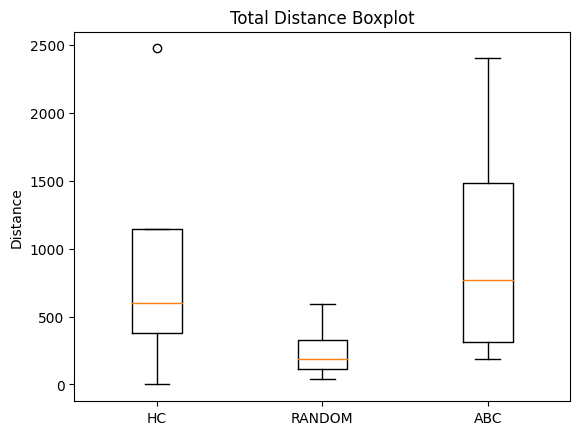

In [ ]:
import matplotlib.pyplot as plt
average_total_distance_HC = 701.2093896713615
min_total_distance_HC = 0
max_total_distance_HC = 2472
std_total_distance_HC  = 502.07898824594025
average_total_distance_RANDOM = 589.2545090180361
min_total_distance_RANDOM = 143.0
max_total_distance_RANDOM = 238.33333333333334
std_total_distance_RANDOM= 40.834988628580476
average_total_distance_ABC= 1179.8466076696166
min_total_distance_ABC = 188
max_total_distance_ABC = 2400
std_total_distance_ABC = 355.41377065477536
# Data for boxplots
data_to_plot = [average_total_distance_HC, average_total_distance_RANDOM, average_total_distance_ABC]
# Create a boxplot
fig, ax = plt.subplots()
ax.boxplot(data.values(), labels=data.keys())
ax.set_title('Total Distance Boxplot')
ax.set_ylabel('Distance')

# Show the plot
plt.show()



Summary and Anova test

In [ ]:

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# Ensure all lists have the same length
min_length = min(len(total_distances_list_ABC), len(total_distances_list_HC), len(total_distances_list_RANDOM))

# Trim the lists to the minimum length
total_distances_list_ABC = total_distances_list_ABC[:min_length]
total_distances_list_HC = total_distances_list_HC[:min_length]
total_distances_list_RANDOM = total_distances_list_RANDOM[:min_length]


# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': total_distances_list_ABC,
    'HC': total_distances_list_HC,
    'RANDOM': total_distances_list_RANDOM,
})

# Combine the distances into a DataFrame
data = pd.DataFrame({
    'ABC': total_distances_list_ABC,
    'HC': total_distances_list_HC,
    'RANDOM': total_distances_list_RANDOM,
})

# Perform One-Way ANOVA
anova_result = f_oneway(
    data['ABC'],
    data['HC'],
    data['RANDOM'],
)

# Display the ANOVA result
print("One-way ANOVA p-value:", anova_result.pvalue)

# Perform Tukey's test for multiple comparisons (post hoc analysis)
flattened_data = np.concatenate([data['ABC'], data['HC'], data['RANDOM']])
labels = np.concatenate([['ABC'] * len(data['ABC']), ['HC'] * len(data['HC']), ['RANDOM'] * len(data['RANDOM']) ])

tukey_result = pairwise_tukeyhsd(flattened_data, labels)

# Display the Tukey's test results
print(tukey_result)

# Additional Statistics
mean_distances = data.mean()
std_distances = data.std()

# Display the mean and standard deviation for each group
print("\nMean distances:")
print(mean_distances)
print("\nStandard deviation distances:")
print(std_distances)


One-way ANOVA p-value: 4.217890438398448e-237
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
   ABC     HC -460.1431   0.0  -511.693 -408.5932   True
   ABC RANDOM -842.4261   0.0 -893.9759 -790.8762   True
    HC RANDOM  -382.283   0.0 -433.8329 -330.7331   True
--------------------------------------------------------

Mean distances:
ABC       1183.465819
HC         723.322734
RANDOM     341.039746
dtype: float64

Standard deviation distances:
ABC       358.883754
HC        503.468750
RANDOM    271.013984
dtype: float64
